# Differences of the 3-channel vs. 4-channel imaging setup.

---
This notebook summarizes the analysis corresponding to the differences of the 3 and 4 channel setup.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300

import sys

sys.path.append("../..")
from src.utils.notebooks.eda import *
from src.utils.notebooks.figure3 import *
from src.utils.notebooks.figure2 import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

seed = 1234
random.seed(1234)
np.random.seed(1234)

%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import re


def sorted_nicely(l):
    """ Sort the given iterable in the way that humans expect."""
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

<IPython.core.display.Javascript object>

In [3]:
def plot_channel_markers_dist(
    data,
    markers,
    marker_labels,
    quantiles=None,
    cut=2,
    plot_type="violin",
    palette=None,
    figsize=[4, 4],
):
    for i in range(len(markers)):
        fig, ax = plot_marker_distribution(
            data,
            figsize=figsize,
            marker=markers[i],
            label_col="condition",
            order=["3channel", "4channel"],
            box_pairs=[
                ("3channel", "4channel"),
            ],
            stat_annot="star",
            quantiles=quantiles,
            cut=cut,
            plot_type=plot_type,
            palette=palette,
        )
        ax.set_xlabel("Imaging condition")
        ax.set_ylabel(marker_labels[i])
        plt.show()
        plt.close()

<IPython.core.display.Javascript object>

In [4]:
color_palette = {"3channel": "purple", "4channel": "pink"}

<IPython.core.display.Javascript object>

---

## 1. Read in data

To assess the differences in the cancer populations compared to the control population, we obtained PBMCs of 10 healthy control samples and 10 cancer patients of various cancer types. For each patient we obtained a number of images of the PBMCs showing their DNA, gH2AX and Lamin A/C content using corresponding fluorescent stains.

First, we read in the required data set that describe each PBMCs by a number of hand-crafted features extracted from the fluorescent images of the cells.

In [5]:
root_data_dir = "../../data/comparison/"
feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"

<IPython.core.display.Javascript object>

In [6]:
all_data = read_in_protein_dataset(
    data_dir=root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
)
all_data["id"] = all_data["sample"] + all_data["timepoint"]
all_data["condition"] = "4channel"
all_data.loc[all_data.loc[:, "sample"] == "p22a", "condition"] = "3channel"
all_data["file_name"] = np.array(list(all_data.index))

Load data: 100%|██████████| 2/2 [00:00<00:00, 23.91it/s]


<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

Before we analyze the data, we will first preprocess it.

To this end, we first remove features with missing values and samples with missing features.

In [7]:
all_data = preprocess_data(all_data, remove_constant_features=False)

Nuclei that did not pass the quality check: 22/754. Remaining: 732.
Removed 29 constant or features with missing values. Remaining: 274.
Removed additional 6 features. Remaining: 268.


<IPython.core.display.Javascript object>

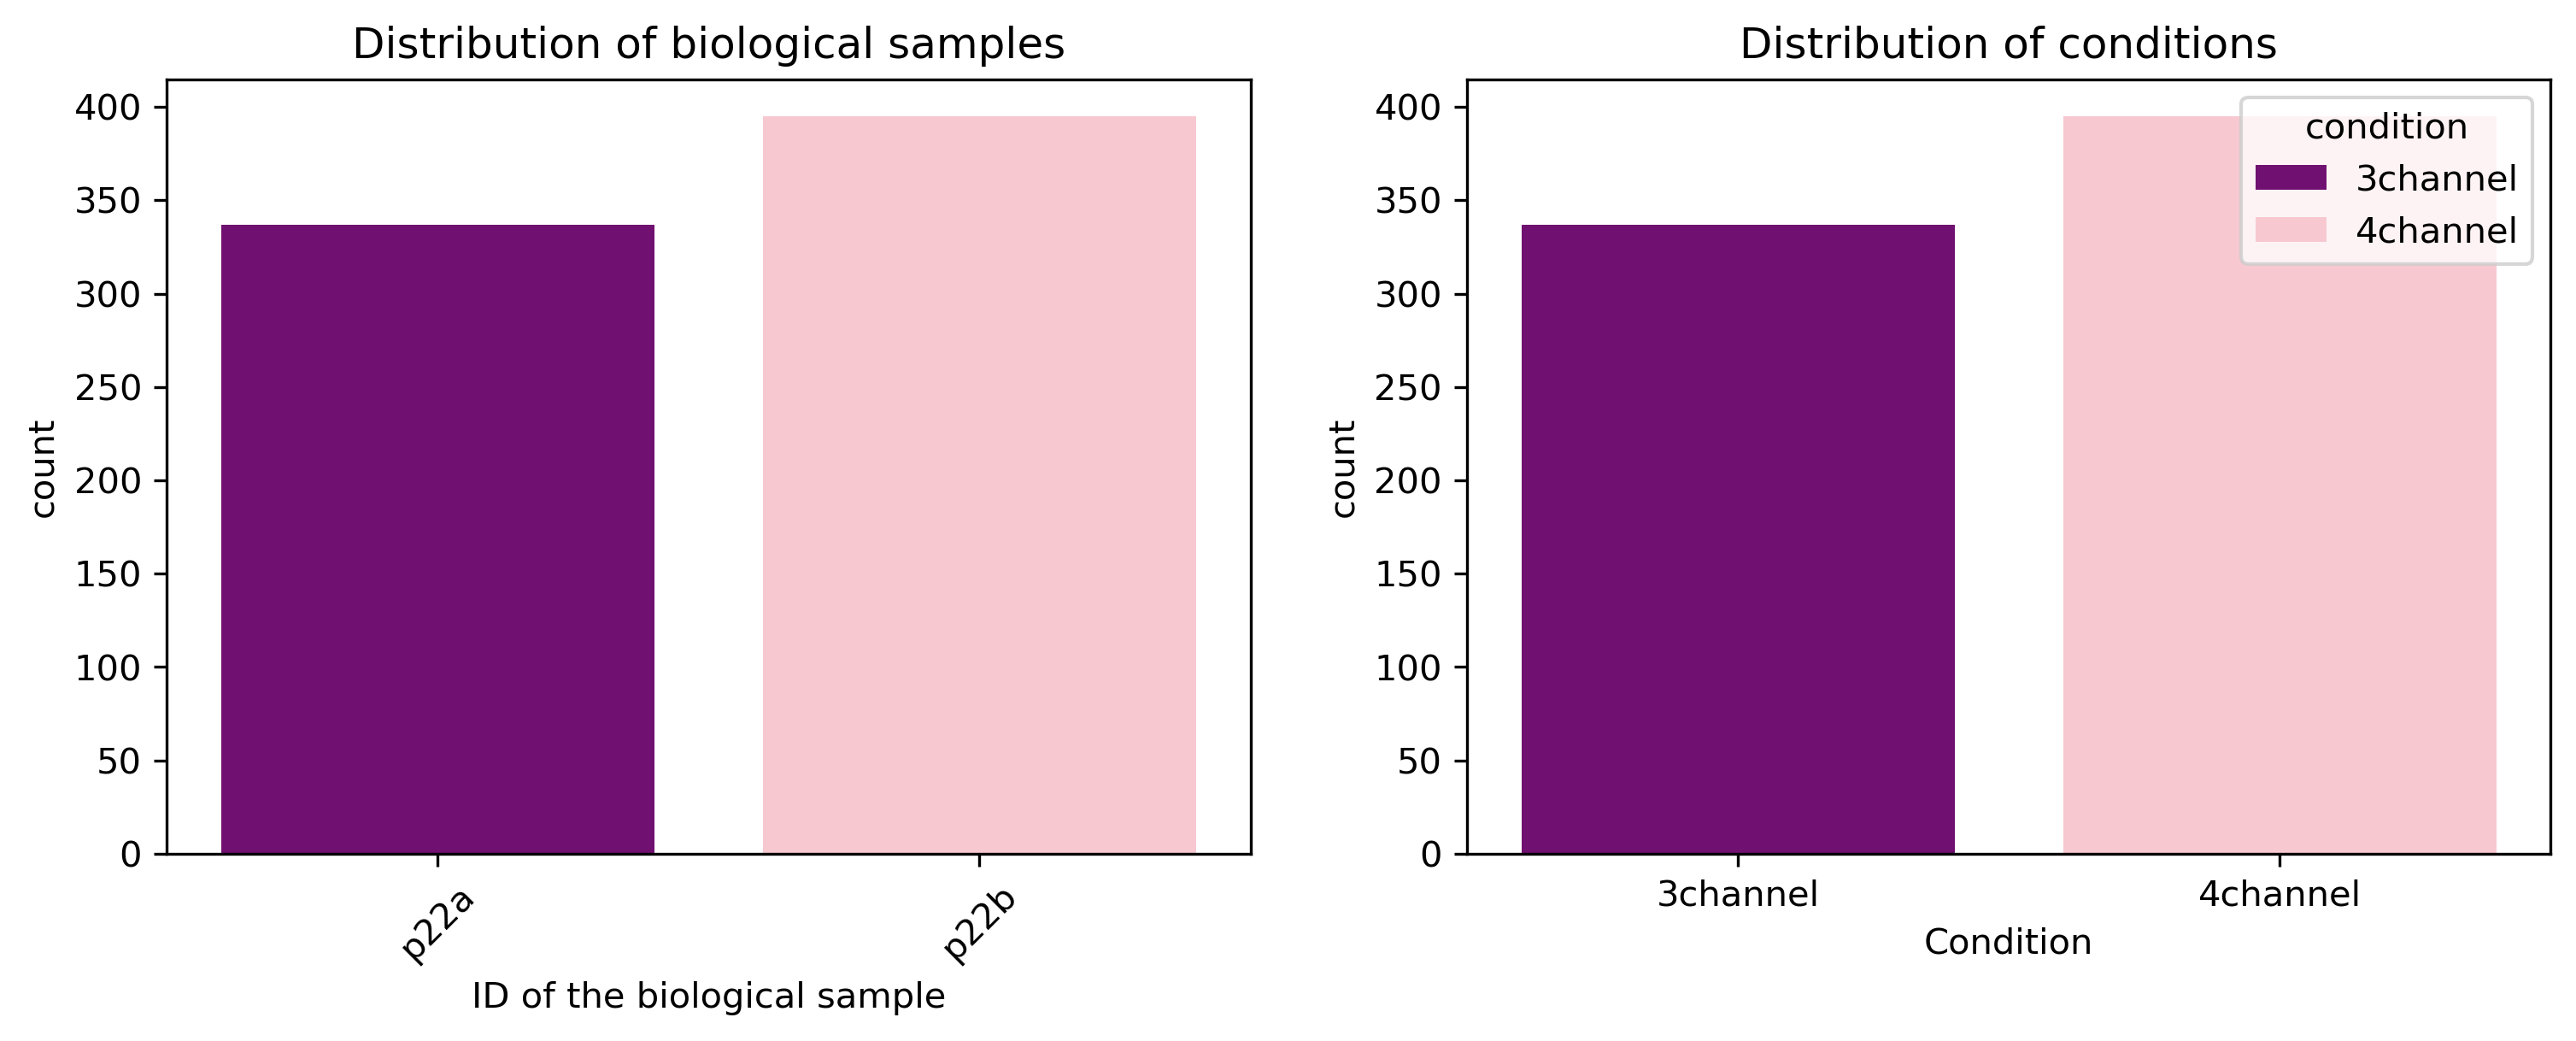

<IPython.core.display.Javascript object>

In [8]:
fig, ax = plt.subplots(figsize=[12, 4], ncols=2)
cond_order = ["3channel", "4channel"]
sample_order = sorted_nicely(np.unique(all_data.loc[:, "sample"]))
ax = ax.flatten()
ax[0] = sns.countplot(
    x="sample",
    data=all_data,
    ax=ax[0],
    order=sample_order,
    hue_order=cond_order,
    hue="condition",
    dodge=False,
    palette=color_palette,
)
ax[0].legend([], [], frameon=False)
ax[0].set_xlabel("ID of the biological sample")
ax[0].set_title("Distribution of biological samples")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

ax[1] = sns.countplot(
    x="condition",
    hue="condition",
    data=all_data,
    ax=ax[1],
    order=cond_order,
    dodge=False,
    palette=color_palette,
    hue_order=cond_order,
)
ax[1].set_xlabel("Condition")
ax[1].set_title("Distribution of conditions")

plt.show()
plt.close()

Note that while the data set consists of 10 cancer patients and 10 healthy controls the number of nuclei varies significantly between each biological sample.

___

#### Subsampling

We first subsample the data set such that for each condition (control vs. cancer) we have the same number of nuclei in the data set. Additionally, we ensure that for the cancer population we have approximately equal number of nuclei from each biological sample.

In [9]:
channel_labels = np.array(all_data.condition)
sampled_data, channel_labels = RandomUnderSampler(random_state=1234).fit_resample(
    all_data, channel_labels
)

<IPython.core.display.Javascript object>

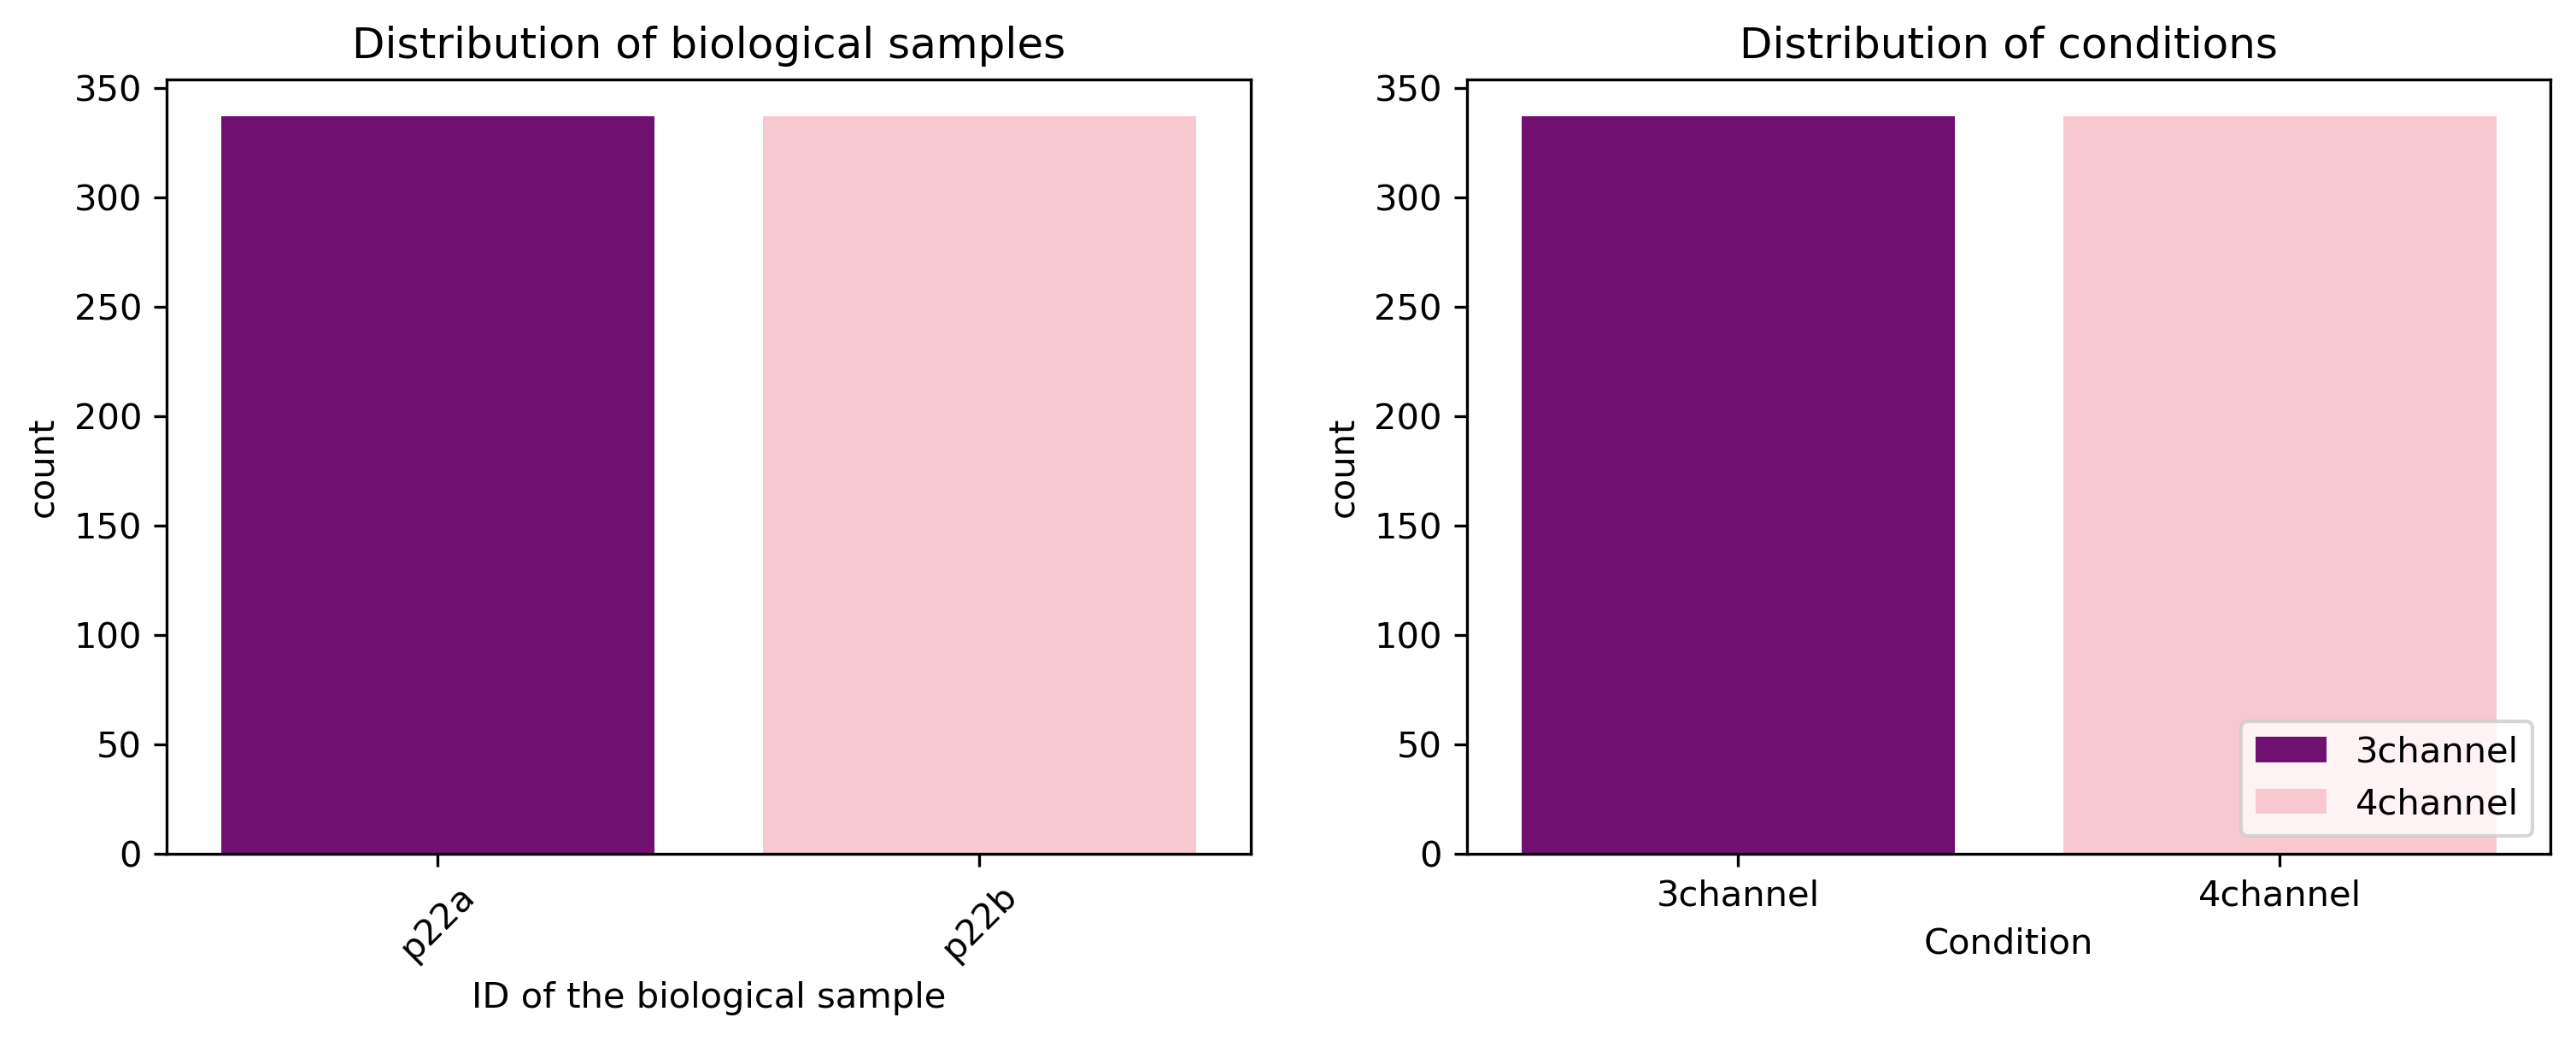

<IPython.core.display.Javascript object>

In [10]:
fig, ax = plt.subplots(figsize=[12, 4], ncols=2)
cond_order = ["3channel", "4channel"]
sample_order = sorted_nicely(np.unique(all_data.loc[:, "sample"]))
ax = ax.flatten()
ax[0] = sns.countplot(
    x="sample",
    data=sampled_data,
    ax=ax[0],
    order=sample_order,
    hue_order=cond_order,
    hue="condition",
    dodge=False,
    palette=color_palette,
)
ax[0].legend([], [], frameon=False)
ax[0].set_xlabel("ID of the biological sample")
ax[0].set_title("Distribution of biological samples")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

ax[1] = sns.countplot(
    x="condition",
    hue="condition",
    data=sampled_data,
    ax=ax[1],
    order=cond_order,
    dodge=False,
    palette=color_palette,
    hue_order=cond_order,
)
ax[1].set_xlabel("Condition")
ax[1].set_title("Distribution of conditions")
ax[1].legend(loc="lower right")

plt.show()
plt.close()

The sampled data set consists of 2160 nuclei from the healthy controls as well as from the cancer patients.

----

#### Sample and feature selection

We now filter out constant features and nuclei with missing features. We will do that for both replicates individually. However, we will also combine the two replicates to provide a joint analysis.

In [11]:
data = preprocess_data(sampled_data, remove_constant_features=True)

Nuclei that did not pass the quality check: 0/674. Remaining: 674.
Removed 5 constant or features with missing values. Remaining: 263.
Removed additional 0 features. Remaining: 263.


<IPython.core.display.Javascript object>

---

#### Data preparation

After sampling the data, we will now prepare the data for the consecutive analysis, i.e. extracting only chrometric features and corresponding metadata information.

In [12]:
all_chrometric_data = get_chrometric_data(
    data,
    proteins=["gh2ax", "lamin"],
    exclude_dna_int=True,
)

sample_labels = data.loc[:, "sample"]
cond_labels = data.loc[:, "condition"]

<IPython.core.display.Javascript object>

Finally, we remove highly correlated features (Pearson $\rho > 0.8$) from the chrometric features.

In [13]:
chrometric_data = remove_correlated_features(all_chrometric_data, threshold=0.8)

Removed 146/196 features with a Pearson correlation above 0.8. Remaining: 50


<IPython.core.display.Javascript object>

---

## 3. Panels

Now we generate the individual panels for figure 2 of the paper.


### 3a. Visualization of the 3channel vs 4 channel populations

In [14]:
image_file_path = "preprocessed/full_pipeline/segmentation/nuclei_images"
sampled_3ch_images = get_random_images(
    data.loc[data.condition == "3channel"],
    image_file_path,
    data_dir_col="data_dir",
    n_images=36,
    seed=1234,
    file_ending=".tif",
)

sampled_4ch_images = get_random_images(
    data.loc[data.condition == "4channel"],
    image_file_path,
    data_dir_col="data_dir",
    n_images=36,
    seed=1234,
    file_ending=".tif",
)

<IPython.core.display.Javascript object>

#### 3 channel population

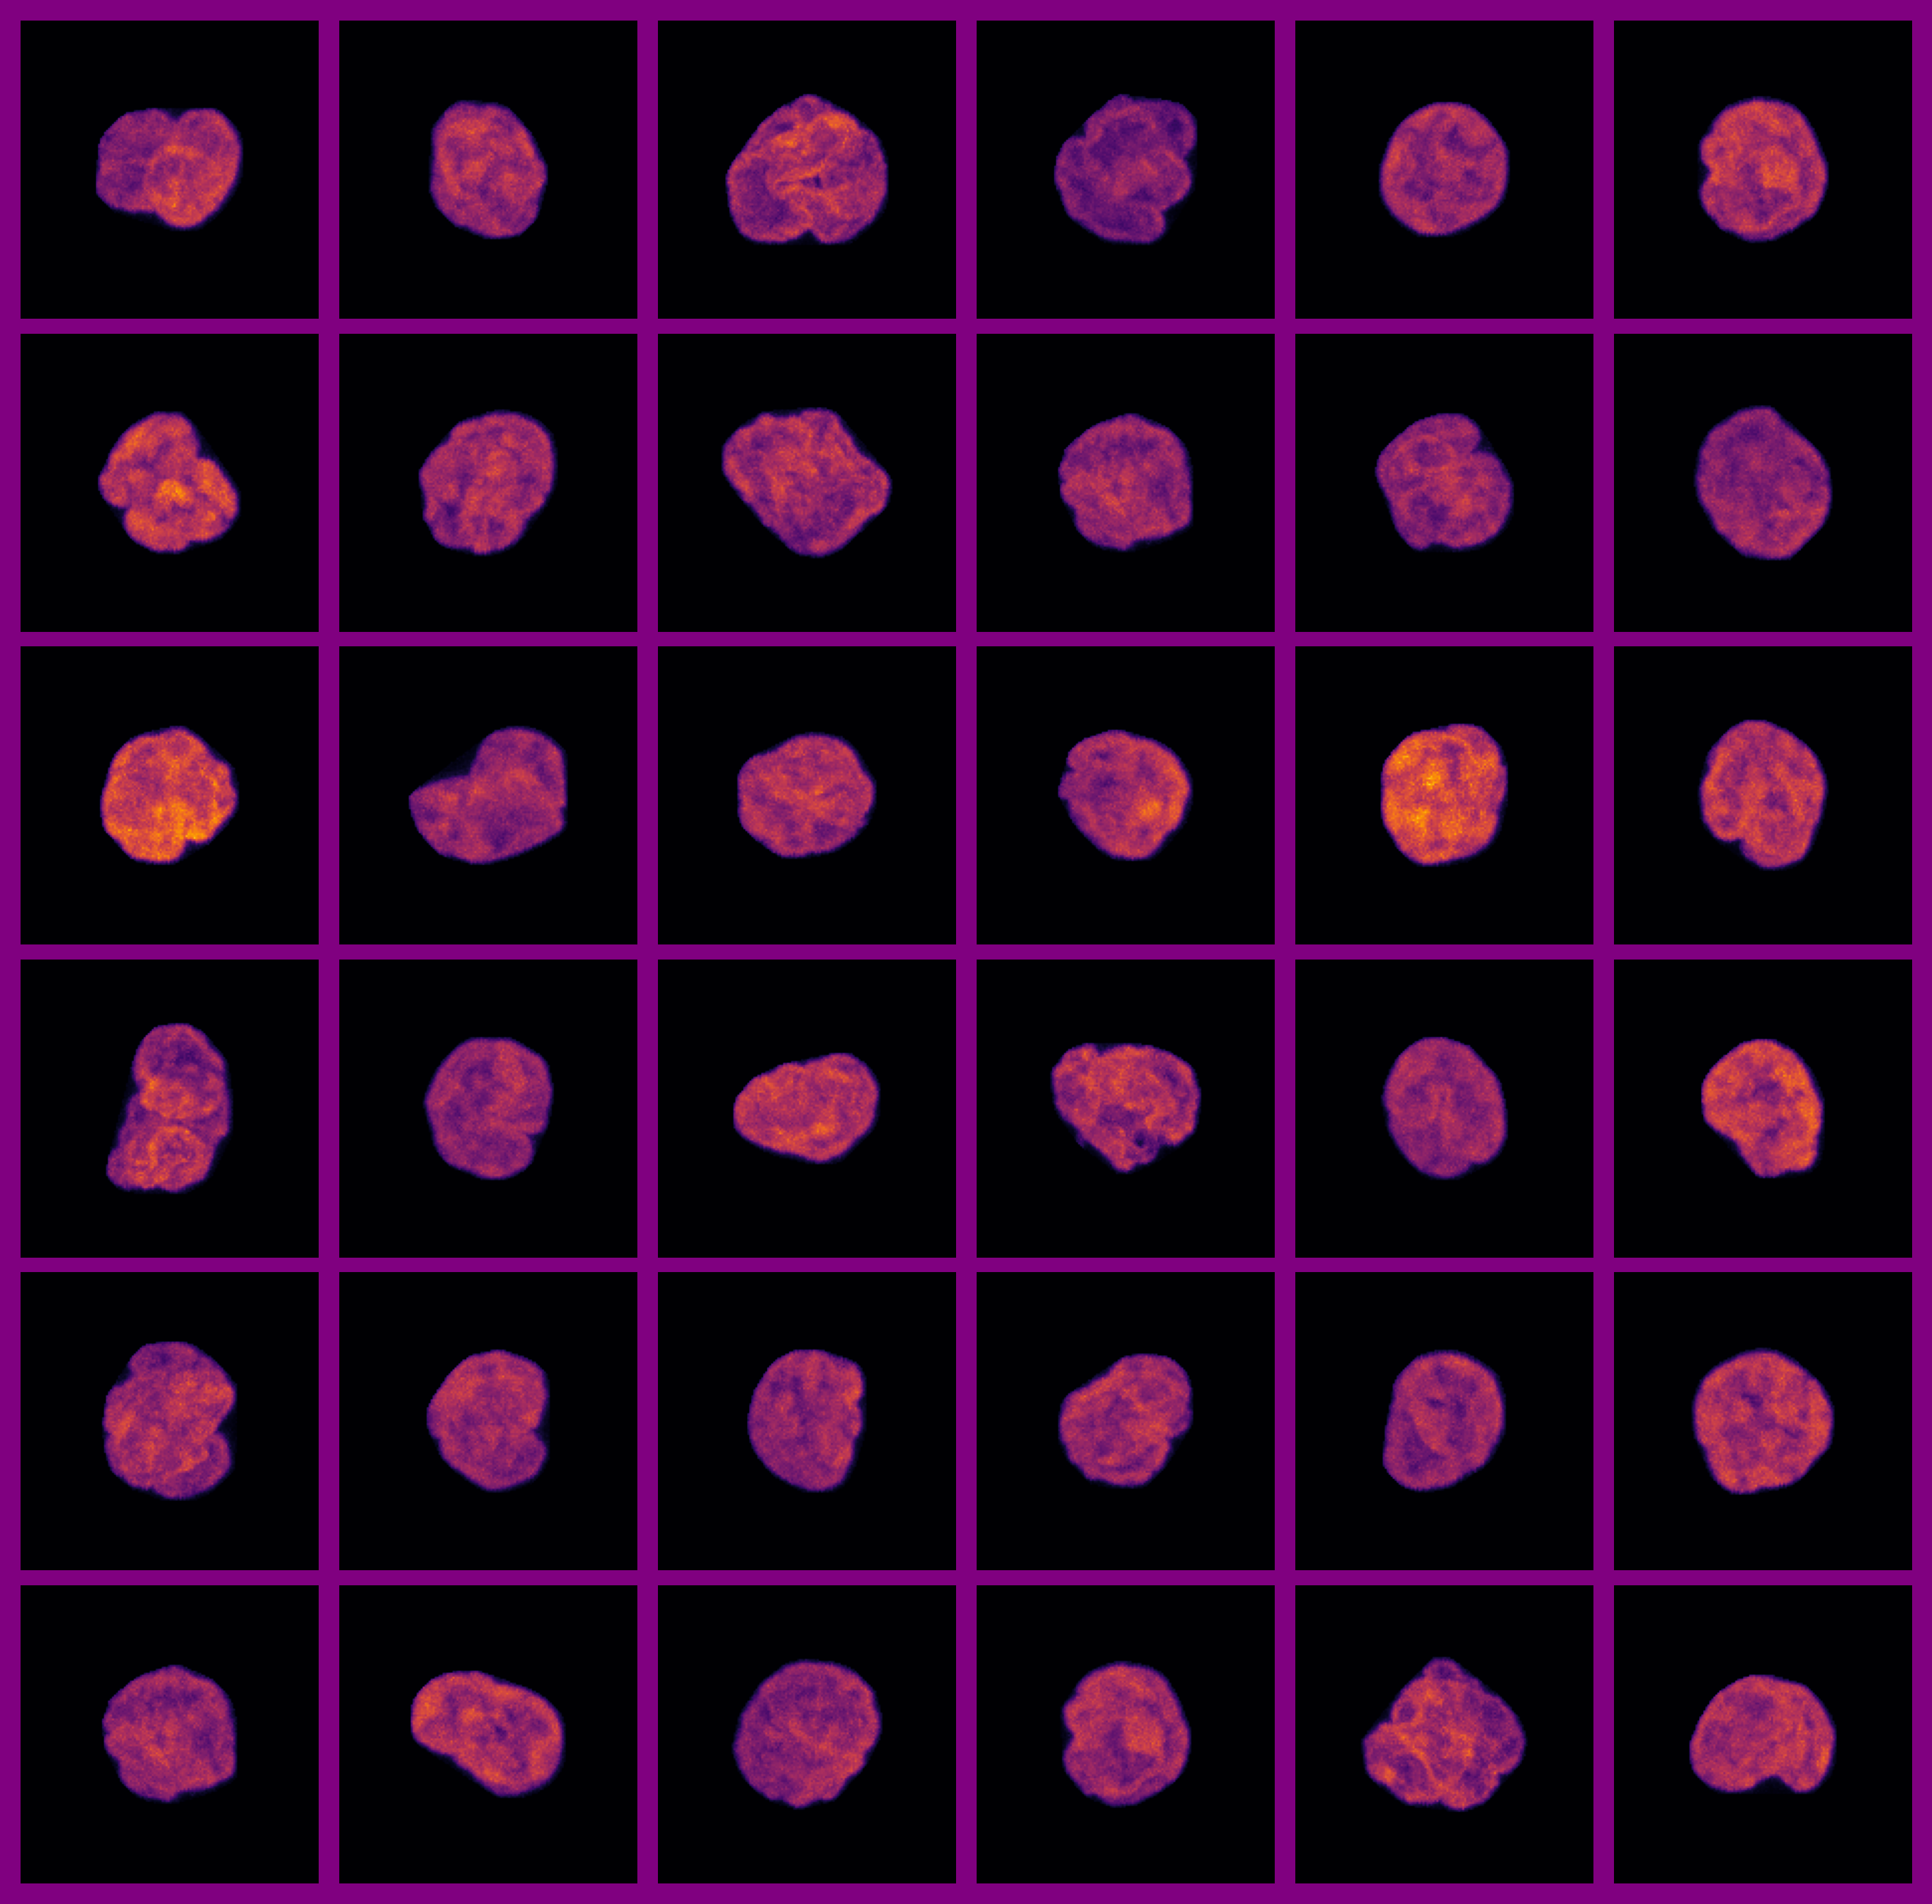

<IPython.core.display.Javascript object>

In [15]:
fig_3ch, ax_3ch = plot_montage(
    sampled_3ch_images, pad_size=150, cmap="inferno", channel_first=False
)
fig_3ch.set_facecolor(color_palette["3channel"])

#### Cancer population

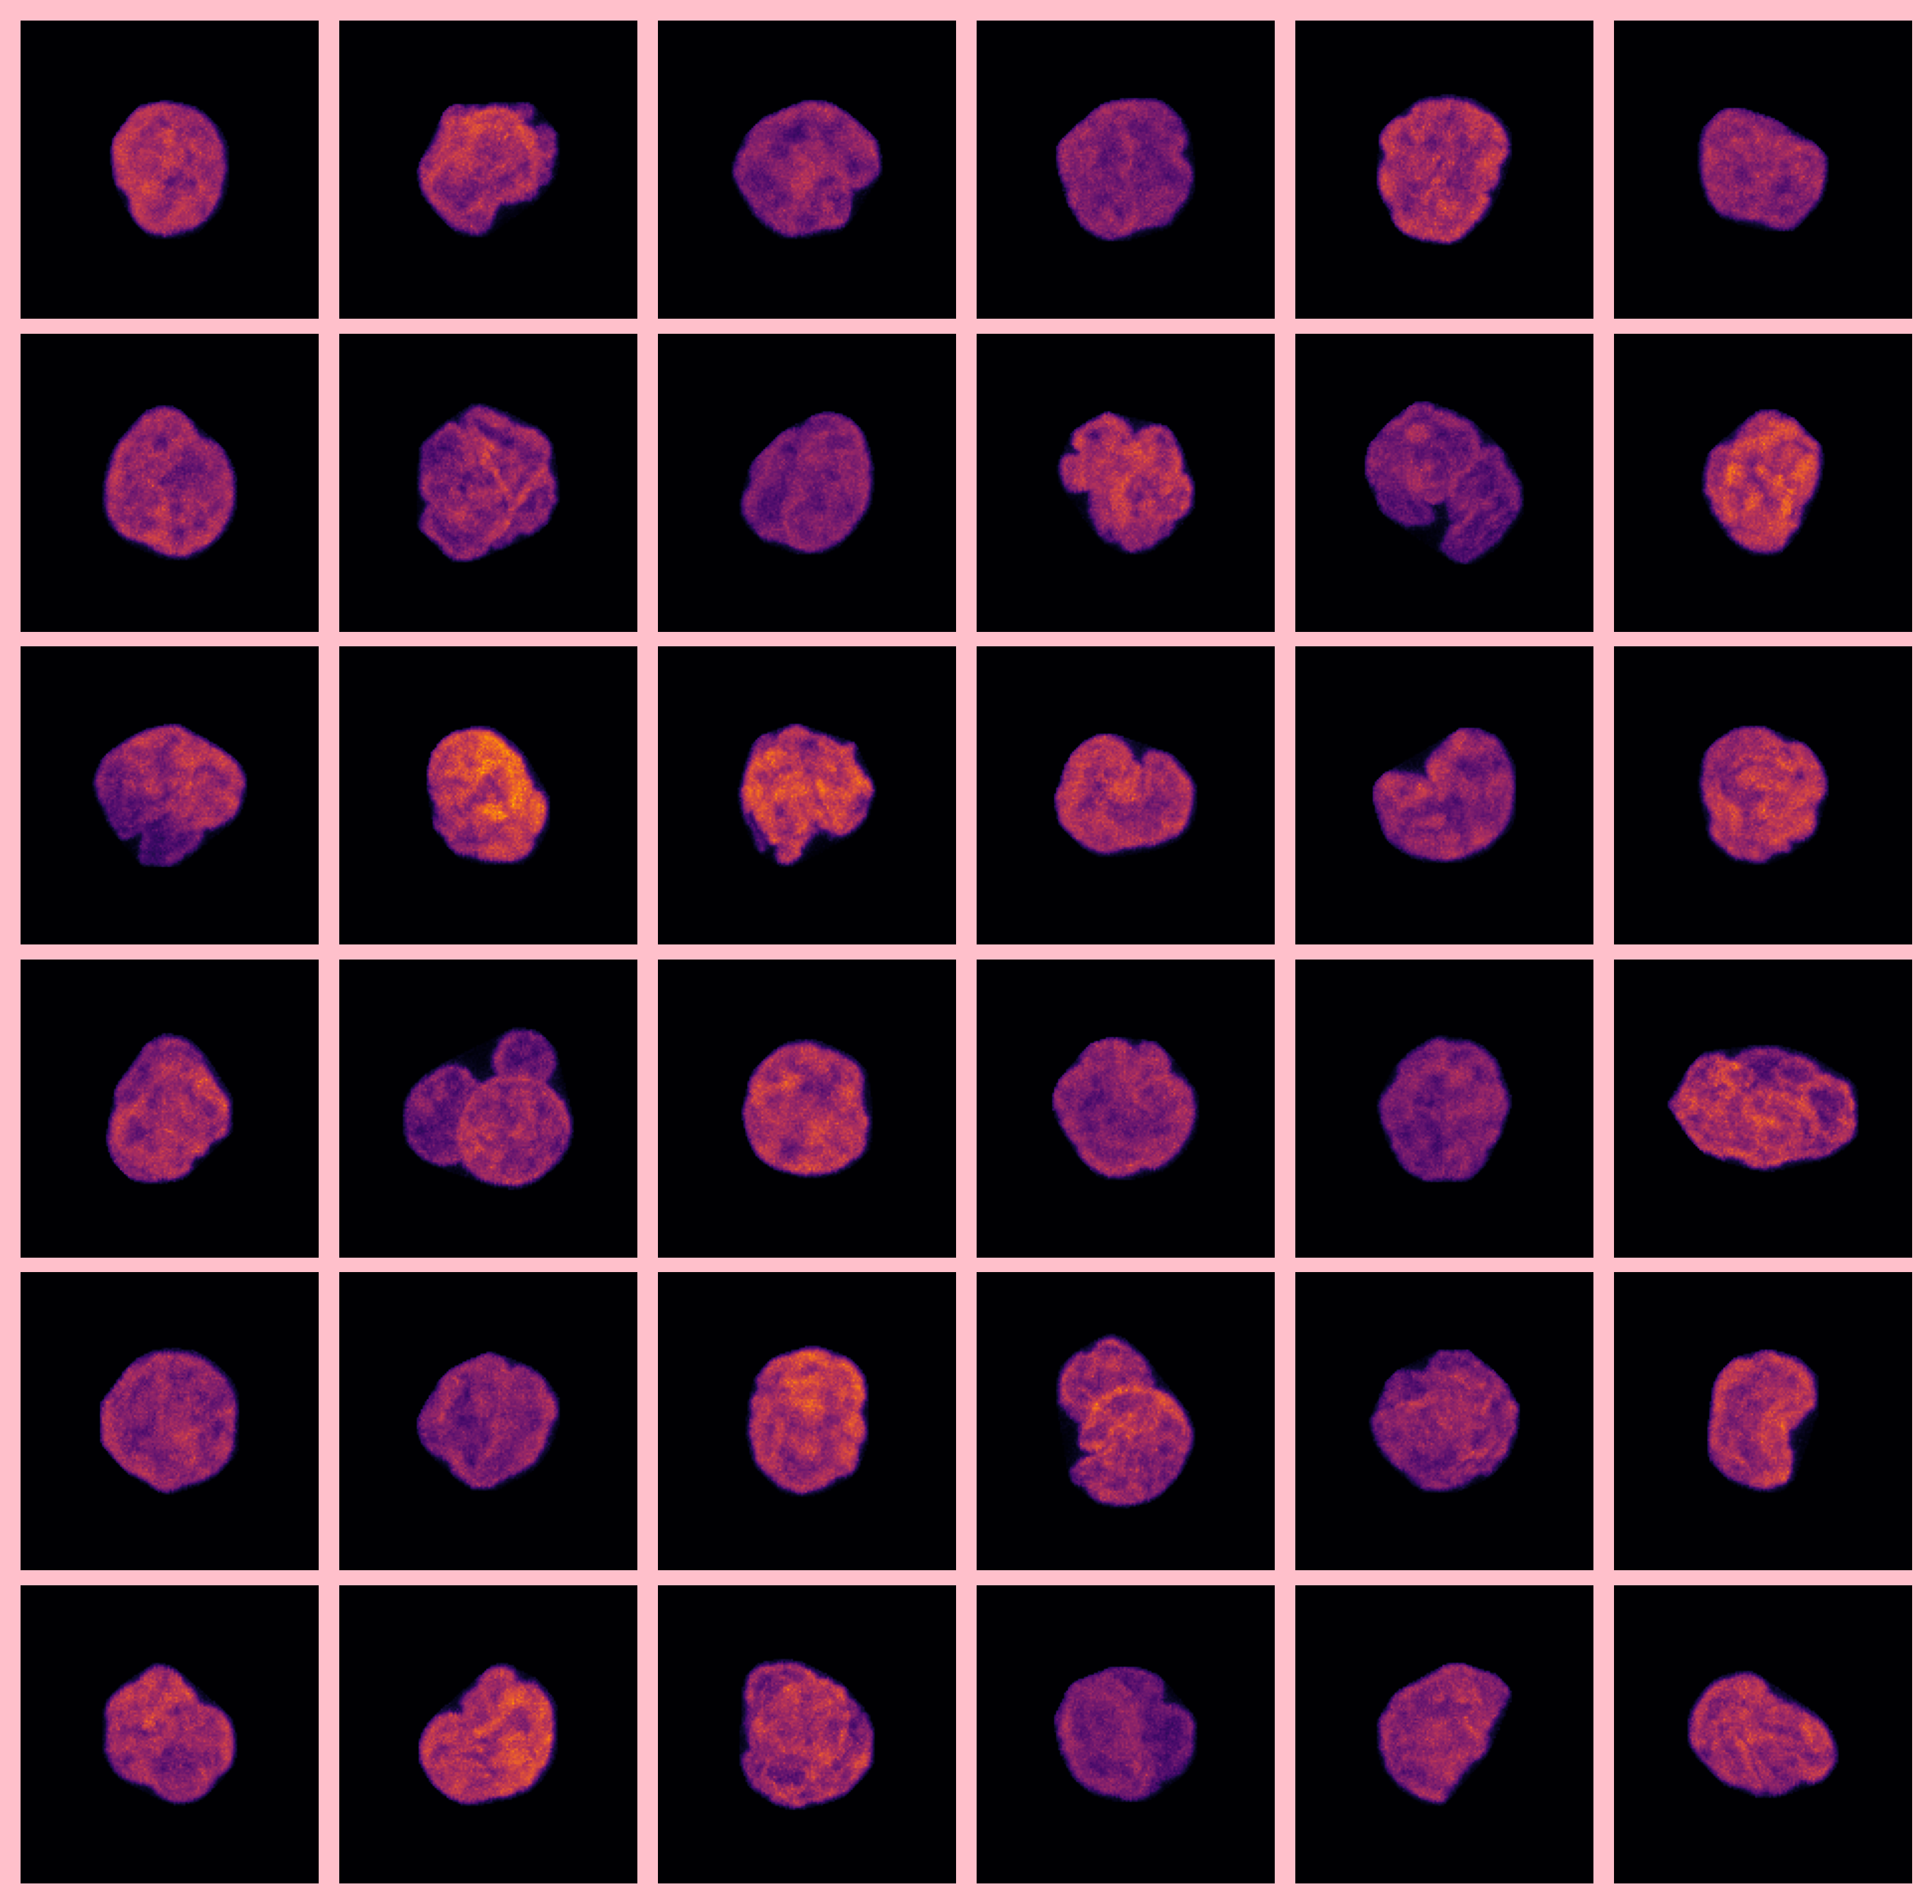

<IPython.core.display.Javascript object>

In [16]:
fig_4ch, ax_4ch = plot_montage(
    sampled_4ch_images, pad_size=150, cmap="inferno", channel_first=True
)
fig_4ch.set_facecolor(color_palette["4channel"])

---

### 3b. Parametric analysis captures small-scale differences between 3 channel and 4 channel setup.

In [17]:
chrometric_embs = get_tsne_embs(chrometric_data)
chrometric_embs["condition"] = np.array(cond_labels)
chrometric_embs["sample"] = np.array(sample_labels)

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<IPython.core.display.Javascript object>

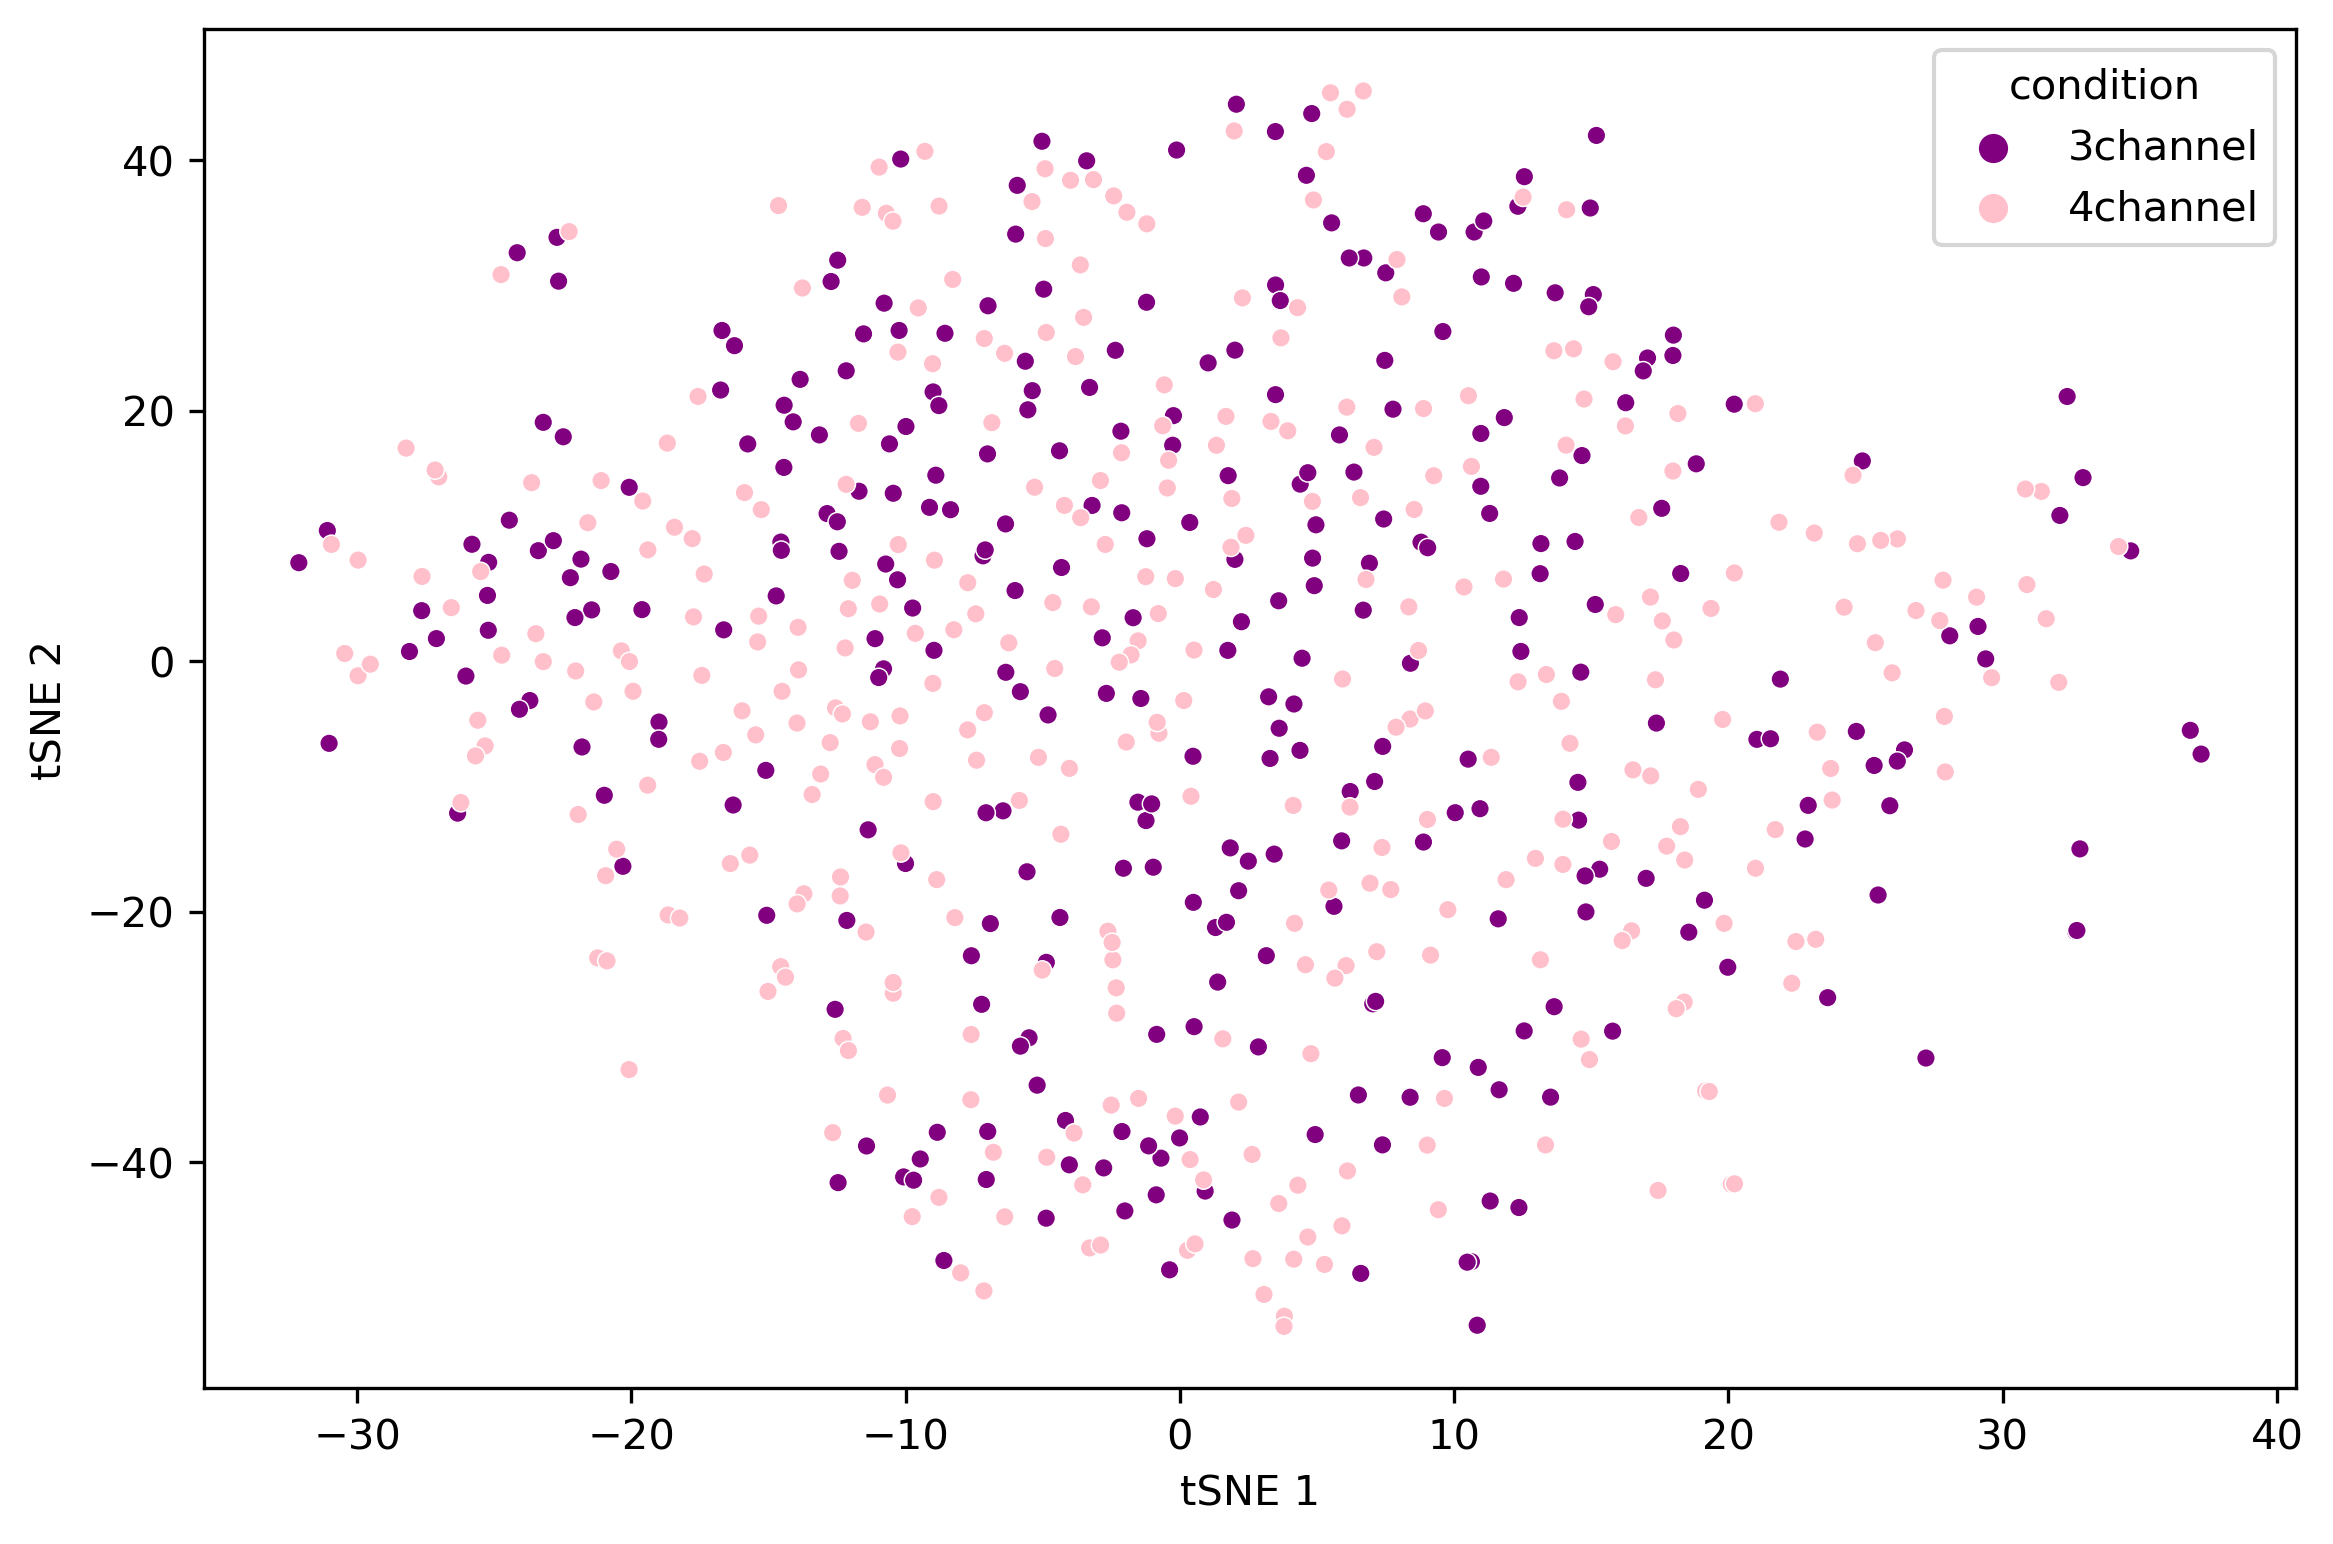

<IPython.core.display.Javascript object>

In [18]:
fig, ax = plt.subplots(figsize=[9, 6])
ax = sns.scatterplot(
    data=chrometric_embs,
    x="tSNE 1",
    y="tSNE 2",
    hue="condition",
    hue_order=cond_order,
    ax=ax,
    s=20,
    marker="o",
    palette=color_palette,
)
plt.show()

---

#### Classification of the 3-channel resp. 4-channel PBMCs

In [19]:
rfc = RandomForestClassifier(
    n_estimators=500, n_jobs=10, random_state=seed, class_weight="balanced"
)

<IPython.core.display.Javascript object>

##### Nuclei split

At first we will split the data randomly on a nuclei-basis, i.e. nuclei of the same biological sample will be likely included in both the training and the test sets.

In [20]:
cond_cv_conf_mtx_nuclei = get_cv_conf_mtx(
    estimator=rfc,
    features=chrometric_data,
    labels=cond_labels,
    scale_features=False,
    n_folds=10,
    order=cond_order,
)
normalized_cv_conf_mtx_nuclei = cond_cv_conf_mtx_nuclei.divide(
    cond_cv_conf_mtx_nuclei.sum(axis=1), axis=0
)

<IPython.core.display.Javascript object>

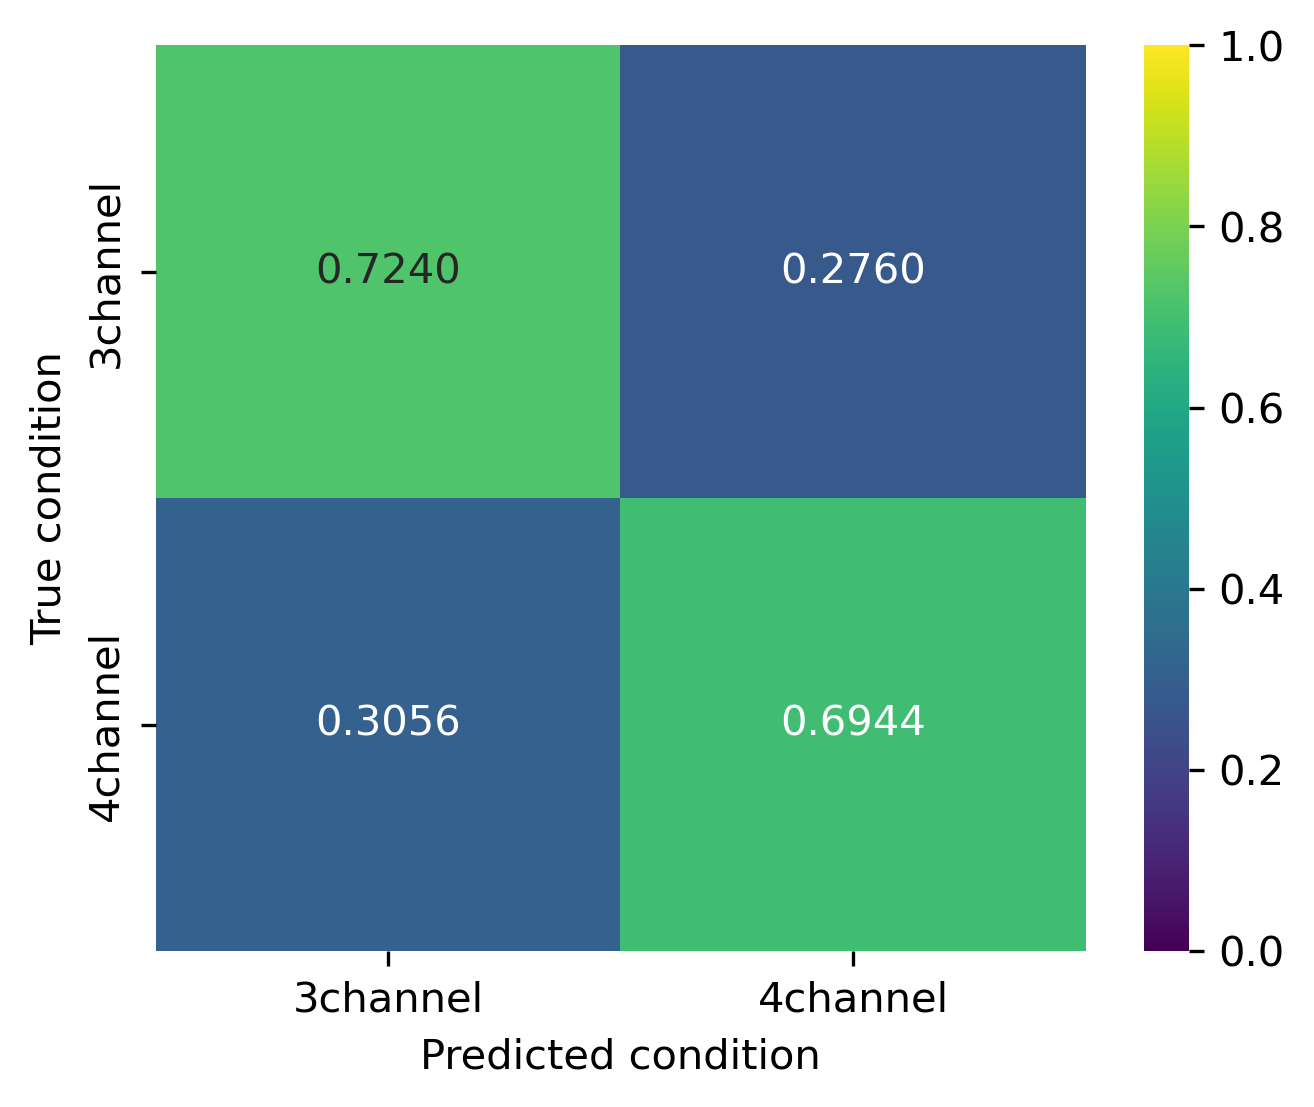

<IPython.core.display.Javascript object>

In [21]:
fig, ax = plt.subplots(figsize=[5, 4])
ax = sns.heatmap(
    normalized_cv_conf_mtx_nuclei,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    vmin=0,
    vmax=1,
    # cbar=False,
)
ax.set_xlabel("Predicted condition")
ax.set_ylabel("True condition")
plt.show()

The classifier is able to accurately distinguish nuclei from the control and cancer population. This suggests that there are large differences with respect to the chrometric phenotypes of PBMCs in the absence compared to in the presence of cancer. While the tSNE plot already suggested that this is the case, a linear discriminant analysis shows that using a linear combination of the chrometric features the two classes can be accurately distinguished.

In [22]:
lda = LinearDiscriminantAnalysis(n_components=1)

<IPython.core.display.Javascript object>

In [23]:
lda_cond_cv_conf_mtx_nuclei = get_cv_conf_mtx(
    estimator=lda,
    features=chrometric_data,
    labels=cond_labels,
    scale_features=True,
    n_folds=10,
    order=cond_order,
)
lda_normalized_cv_conf_mtx_nuclei = lda_cond_cv_conf_mtx_nuclei.divide(
    lda_cond_cv_conf_mtx_nuclei.sum(axis=1), axis=0
)

<IPython.core.display.Javascript object>

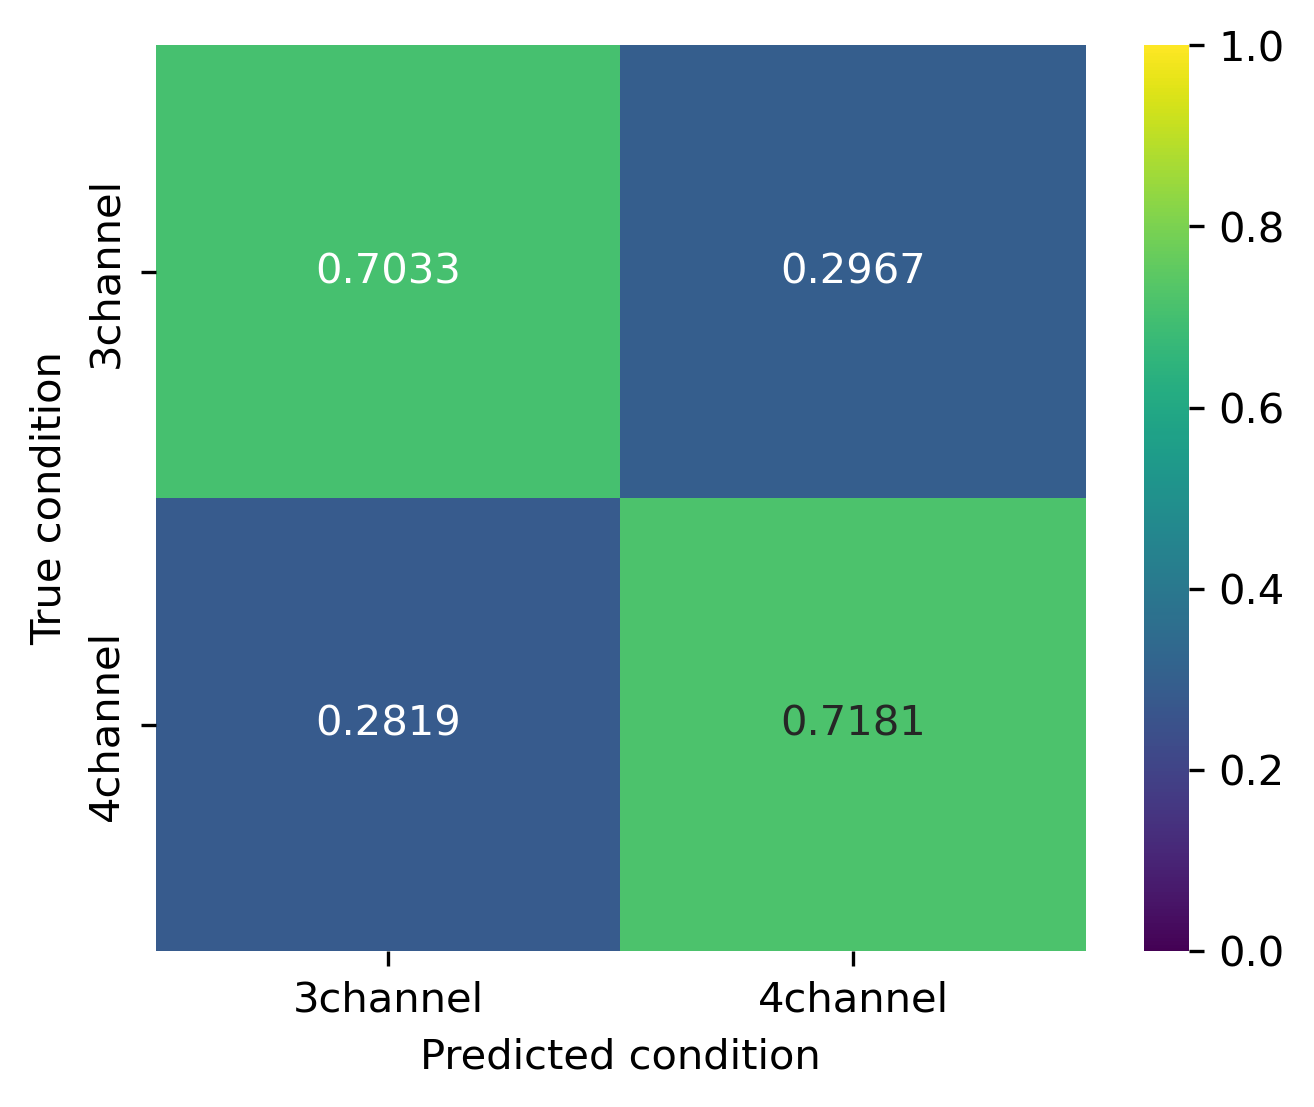

<IPython.core.display.Javascript object>

In [24]:
fig, ax = plt.subplots(figsize=[5, 4])
ax = sns.heatmap(
    lda_normalized_cv_conf_mtx_nuclei,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    vmin=0,
    vmax=1,
    # cbar=False,
)
ax.set_xlabel("Predicted condition")
ax.set_ylabel("True condition")
plt.show()

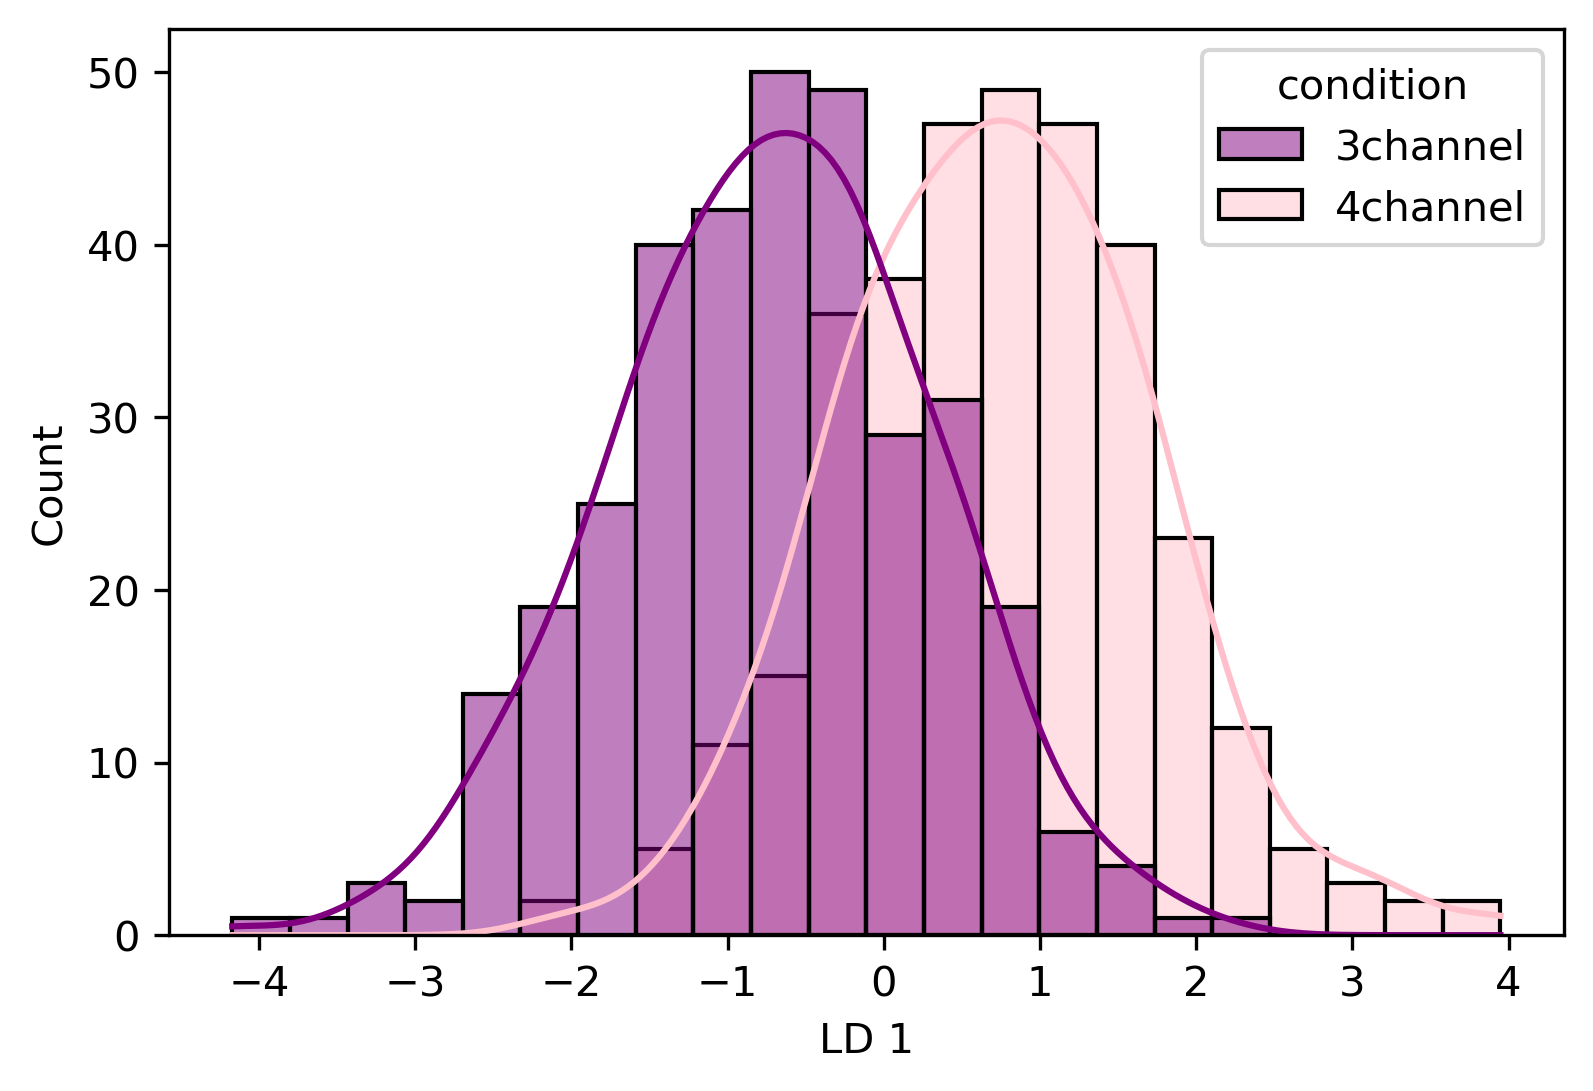

<IPython.core.display.Javascript object>

In [25]:
lda_transformed = pd.DataFrame(
    lda.fit(chrometric_data, cond_labels).transform(chrometric_data),
    columns=["LD 1"],
    index=chrometric_data.index,
)
lda_transformed["condition"] = np.array(cond_labels)
lda_transformed["sample"] = np.array(sample_labels)
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.histplot(
    data=lda_transformed,
    x="LD 1",
    hue="condition",
    hue_order=cond_order,
    palette=color_palette,
    kde=True,
)

---

### 3c. Nuclear chromatin biomarkers identifying cancer populations


#### Feature importance

After having validated that there are significant differences between the 3 channel and the 4 channel population with respect to the chrometric pheontypes of the PBMCS, we next assess the implicit feature importance of a RandomForest classifier trained on the task to distinguish between 3 channel and 4 channel samples in order to get an idea of the features which are most indicative of the channel condition.

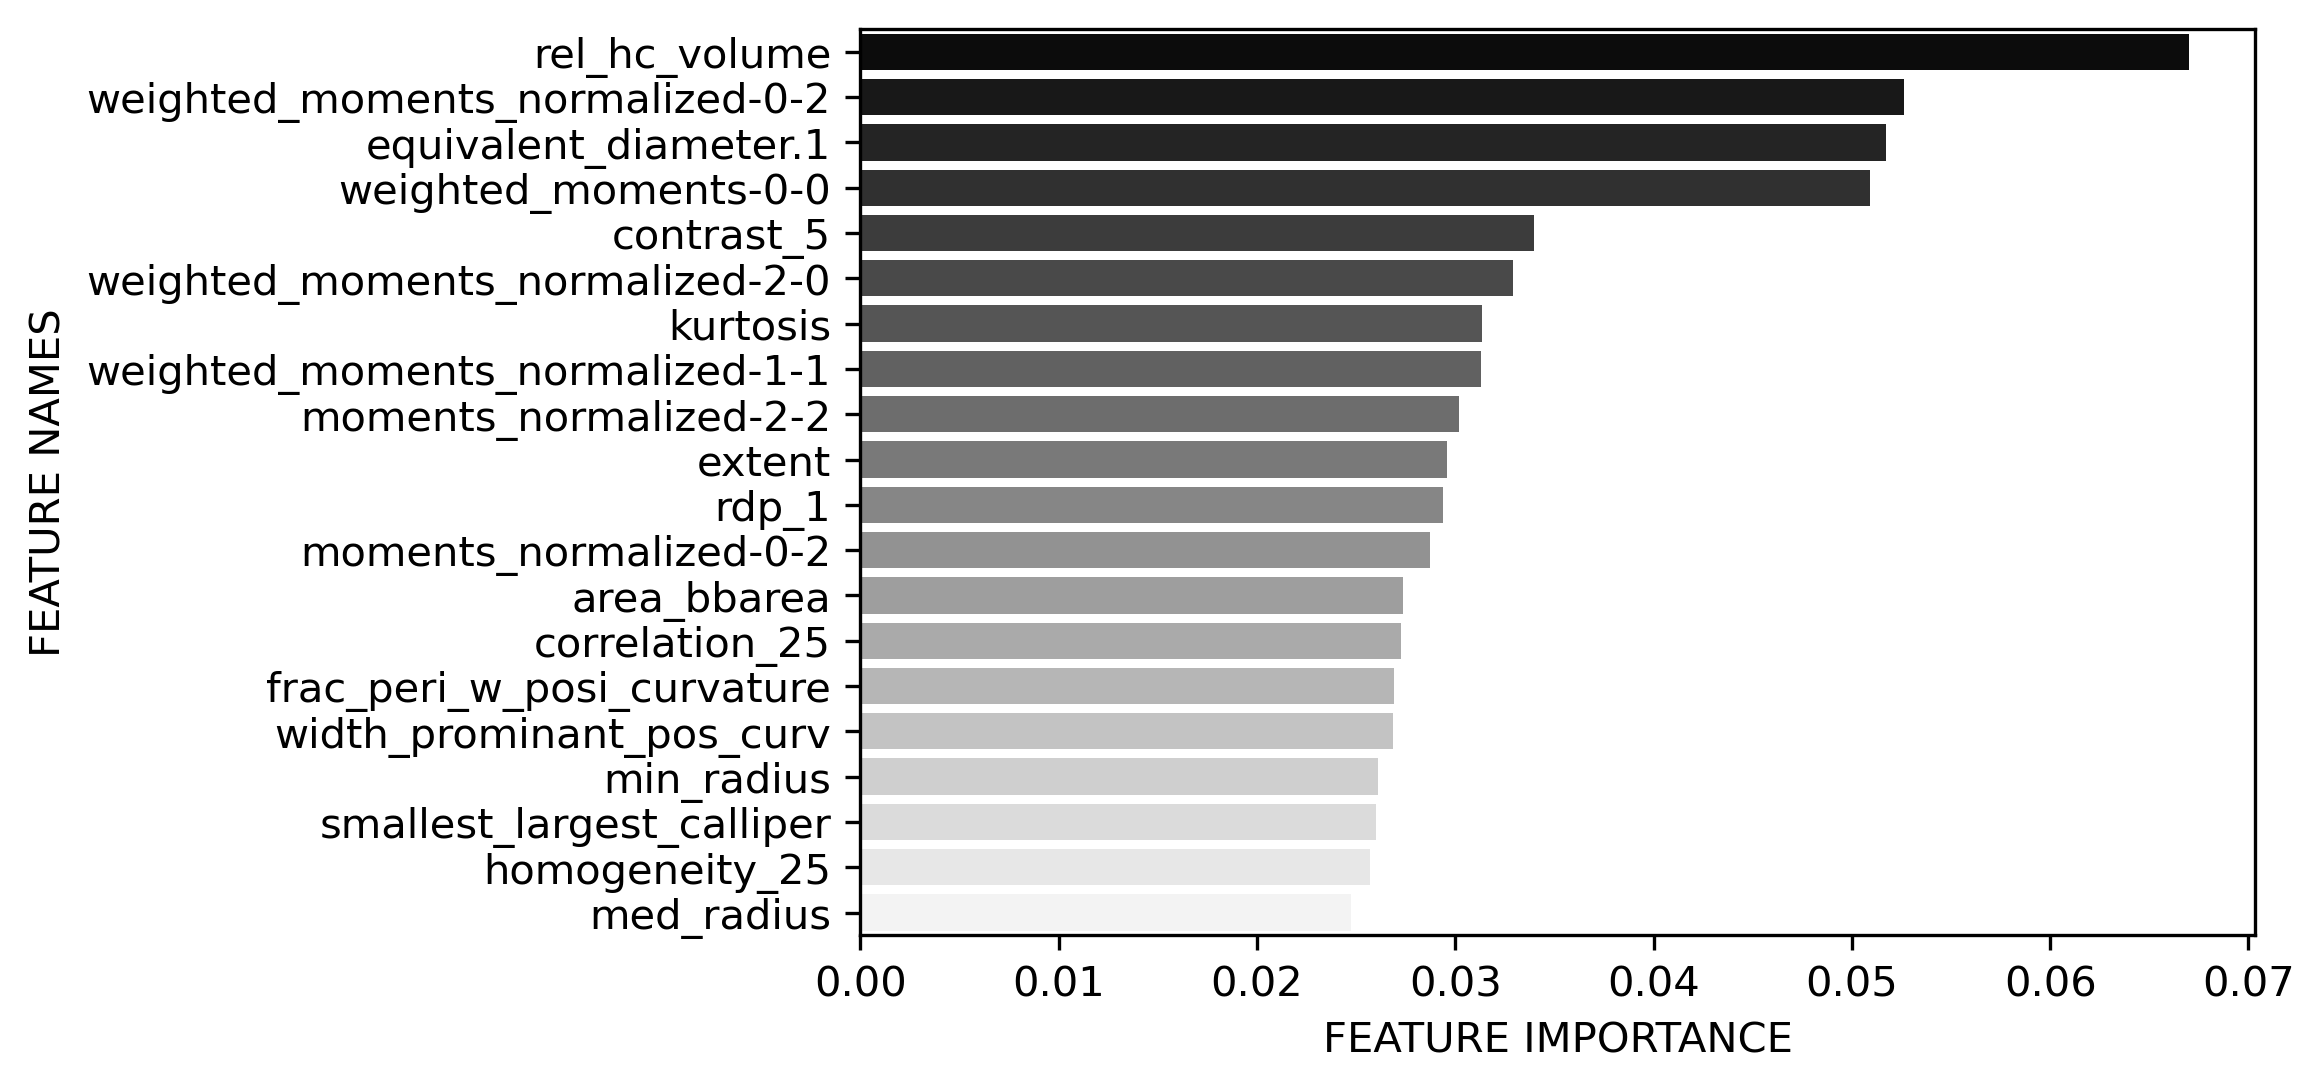

<IPython.core.display.Javascript object>

In [26]:
fig, ax = plot_feature_importance_for_estimator(
    rfc,
    chrometric_data,
    cond_labels,
    scale_features=False,
    cmap="gray",
    figsize=[6, 4],
)

The analysis suggests that the heterochromatin content, the size of the nucleus, its shape as well as the DNA intensity distribution of the DNA inside the nucleus are altered in the cancer population.

---

### 3c. Nuclear chromatin biomarkers identifying cancer populations

While the previously shown feature importance plots already suggest a number of candidate chrometric biomarkers that capture the differences of the nuclear phenotypes of the PBMCs in the different cancer types, we run marker screen by testing for differential distributions of the individual chrometric features between the control and cancer population. To this end, we apply a t-test to test for difference in the means and adjust for multiple testing using the Benjamini-Hochberg procedure.

In [27]:
marker_screen_results = find_markers(chrometric_data, cond_labels)

Run marker screen:   0%|          | 0/2 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [28]:
marker_screen_results.loc[marker_screen_results.label == "3channel"].head(10)

label                           marker        fc  abs_delta_fc  \
48  3channel                    rel_hc_volume  0.972209      0.027791   
25  3channel             weighted_moments-0-0  1.073184      0.073184   
26  3channel  weighted_moments_normalized-0-2  0.912841      0.087159   
19  3channel                       contrast_5  1.096391      0.096391   
17  3channel                         kurtosis  1.368701      0.368701   
30  3channel  weighted_moments_normalized-2-0  0.940029      0.059971   
47  3channel                           extent  1.020298      0.020298   
28  3channel  weighted_moments_normalized-1-1 -0.252276      1.252276   
36  3channel            weighted_moments_hu-3  0.715382      0.284618   
12  3channel                     med_neg_curv  0.949856      0.050144   

            pval   pval_adjust  
48  4.393179e-11  2.196590e-09  
25  2.721359e-09  6.803399e-08  
26  6.362912e-08  1.060485e-06  
19  5.917876e-06  7.397345e-05  
17  2.081290e-04  2.081290e-03  
30  5.206084e-04  4.338404e-03  
47  5.105984e-03  3.647131e-02  
28  1.299388e-02  8.121176e-02  
36  1.849496e-02  1.027498e-01  
12  2.549210e-02  1.274605e-01

<IPython.core.display.Javascript object>

We find that the most significantly different features are a number of features related to DNA intensity distribution, texture and the chromatin content.

---

As a joint proxy to study the alterations in size, we focus at the nuclear volume, the variation in the shape by the concavity as well as the aspect ratio of the nucleus and the change in chromatin compaction by the relative heterochromatin to euchromatin ratio.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3channel vs. 4channel: t-test independent samples with Benjamini-Hochberg correction, P_val:2.214e-01 t=1.224e+00


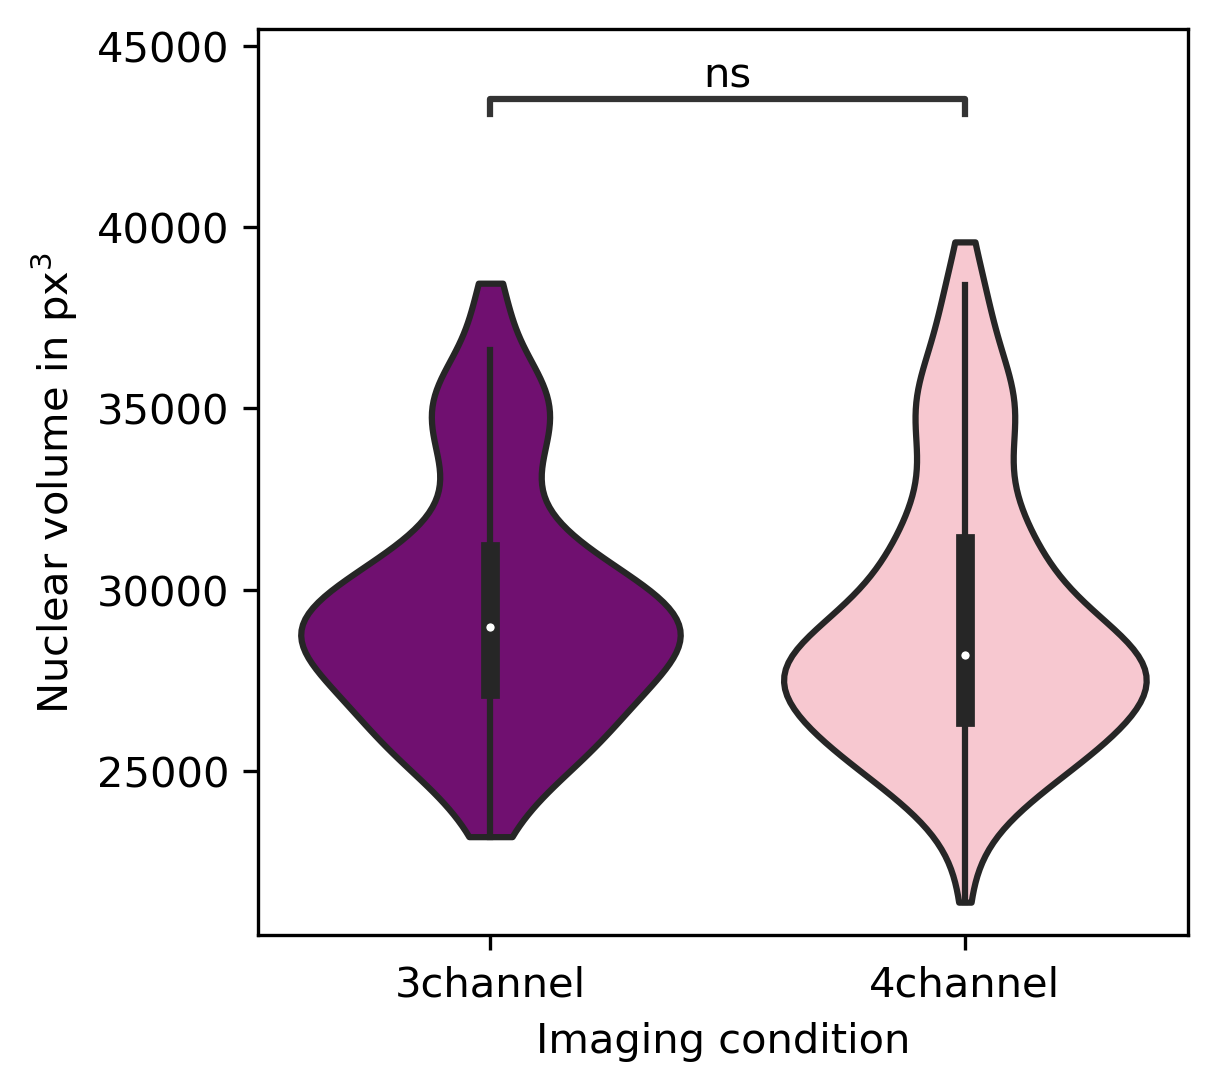

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3channel vs. 4channel: t-test independent samples with Benjamini-Hochberg correction, P_val:4.491e-11 t=-6.697e+00


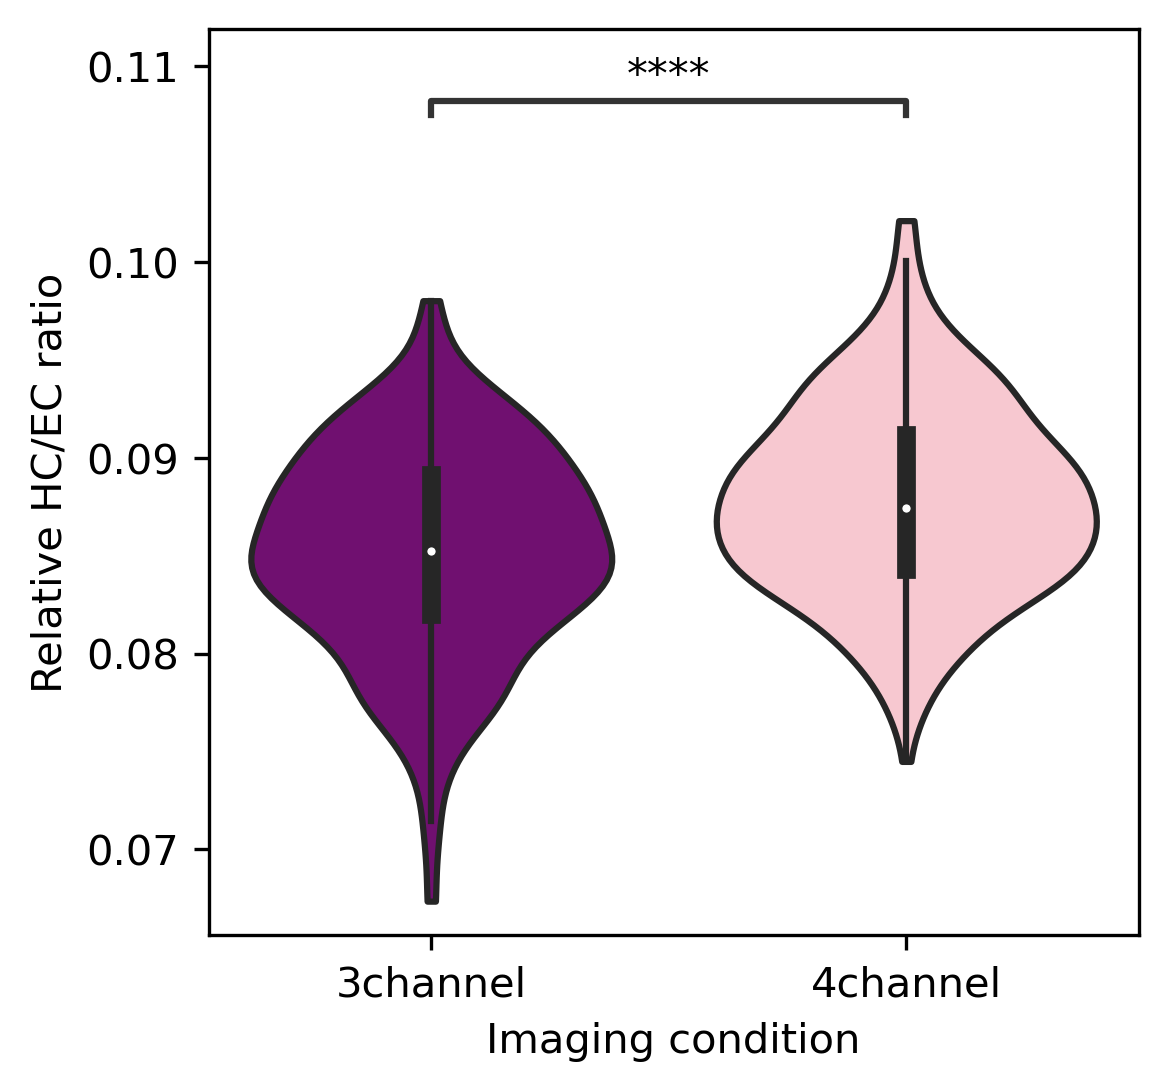

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3channel vs. 4channel: t-test independent samples with Benjamini-Hochberg correction, P_val:5.917e-06 t=4.566e+00


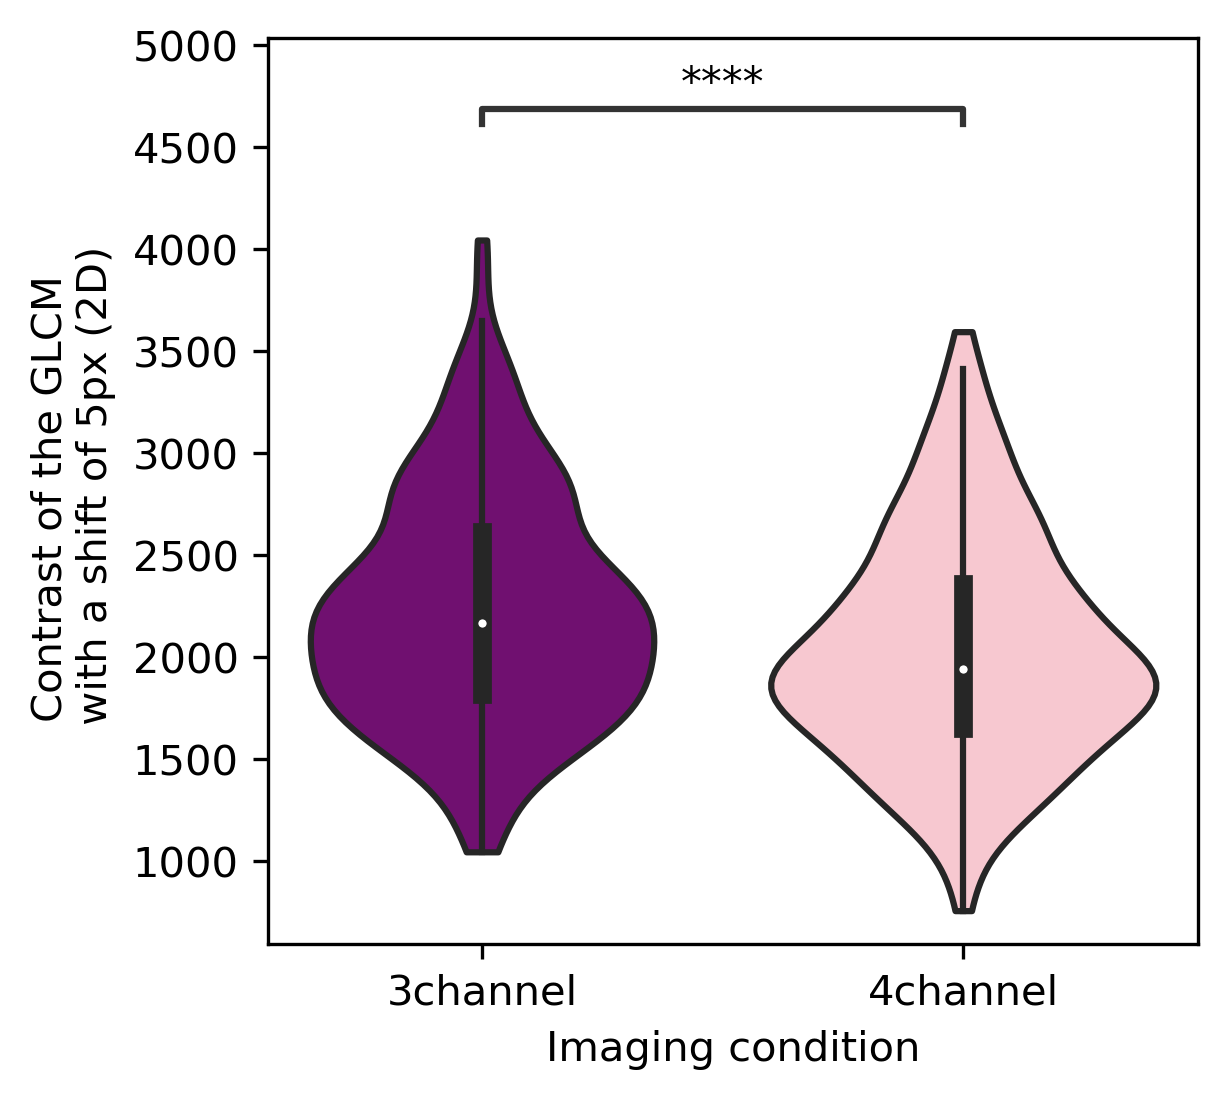

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3channel vs. 4channel: t-test independent samples with Benjamini-Hochberg correction, P_val:2.072e-04 t=3.731e+00


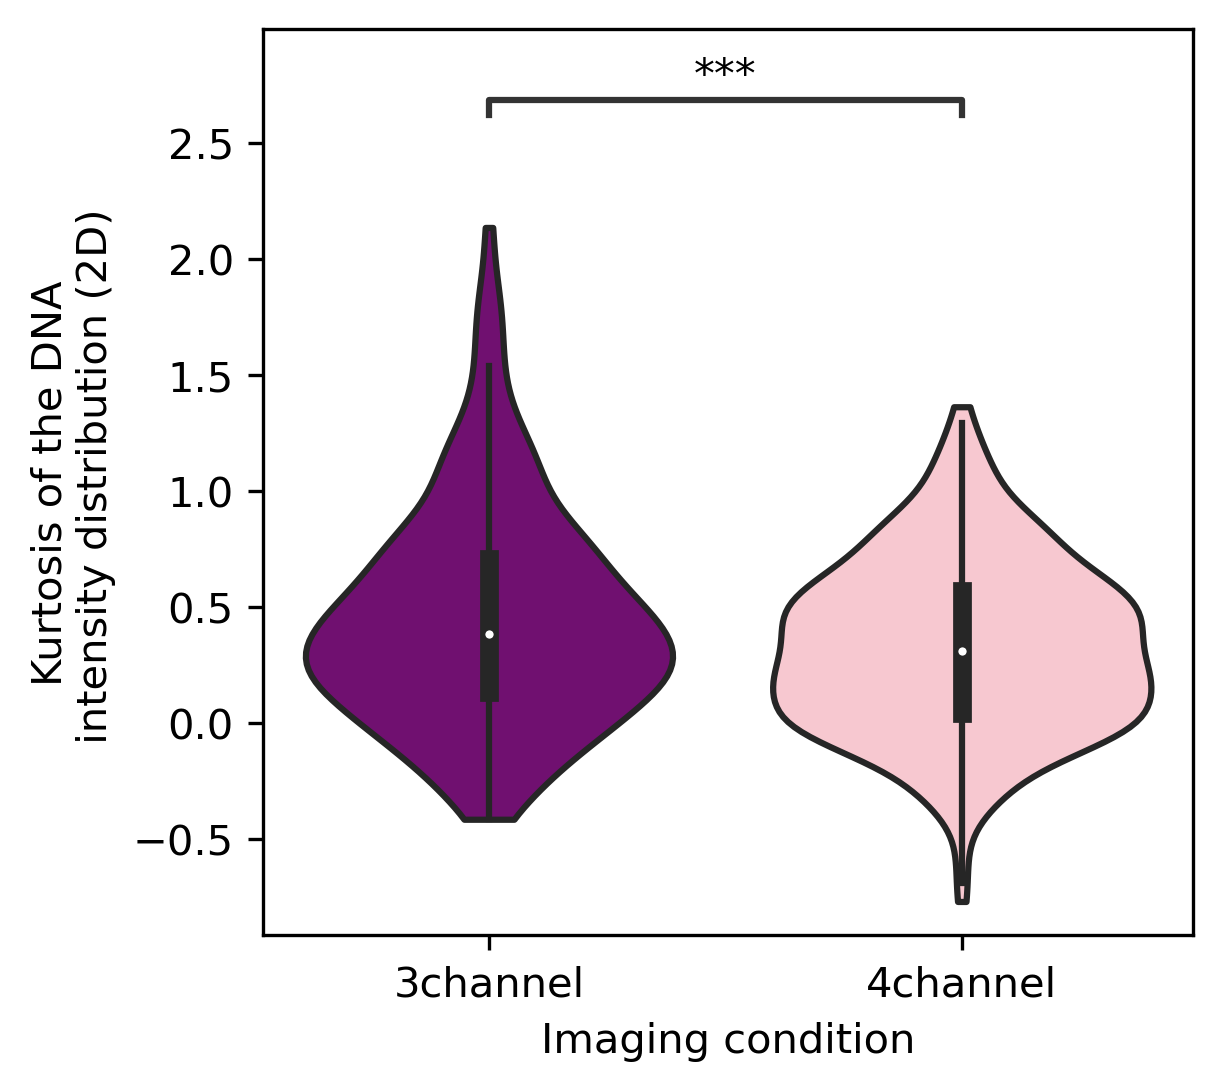

<IPython.core.display.Javascript object>

In [29]:
markers = [
    "nuclear_volume",
    "hc_ec_ratio_3d",
    "contrast_5",
    "kurtosis",
]
marker_labels = [
    r"Nuclear volume in px$^3$",
    "Relative HC/EC ratio",
    "Contrast of the GLCM \n with a shift of 5px (2D)",
    "Kurtosis of the DNA\n intensity distribution (2D)",
]
plot_channel_markers_dist(data, markers, marker_labels, cut=0, palette=color_palette)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3channel vs. 4channel: t-test independent samples with Benjamini-Hochberg correction, P_val:2.214e-01 t=1.224e+00


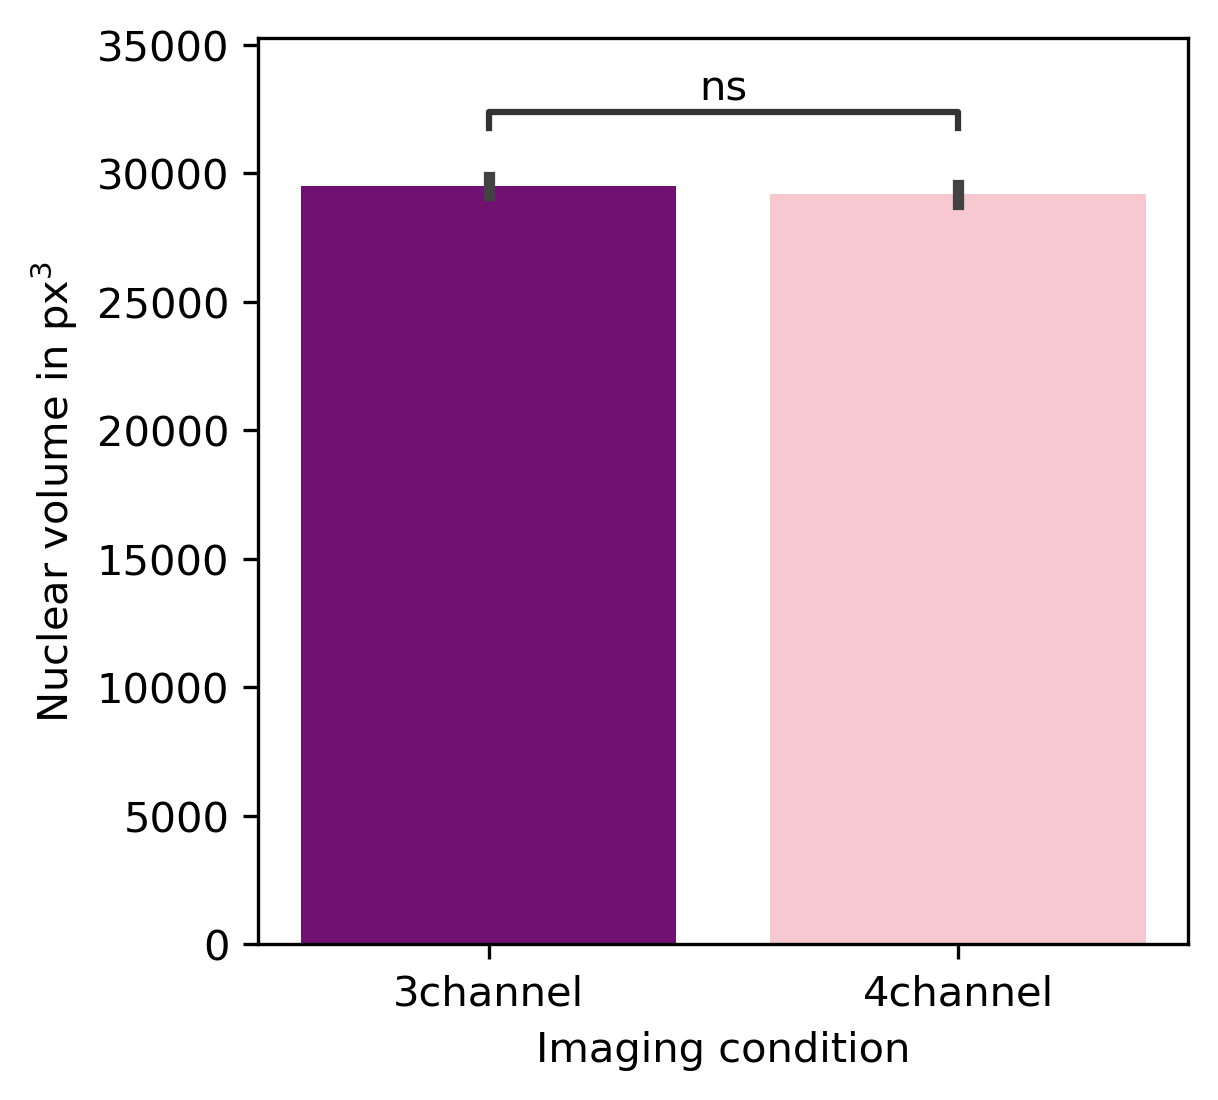

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3channel vs. 4channel: t-test independent samples with Benjamini-Hochberg correction, P_val:4.491e-11 t=-6.697e+00


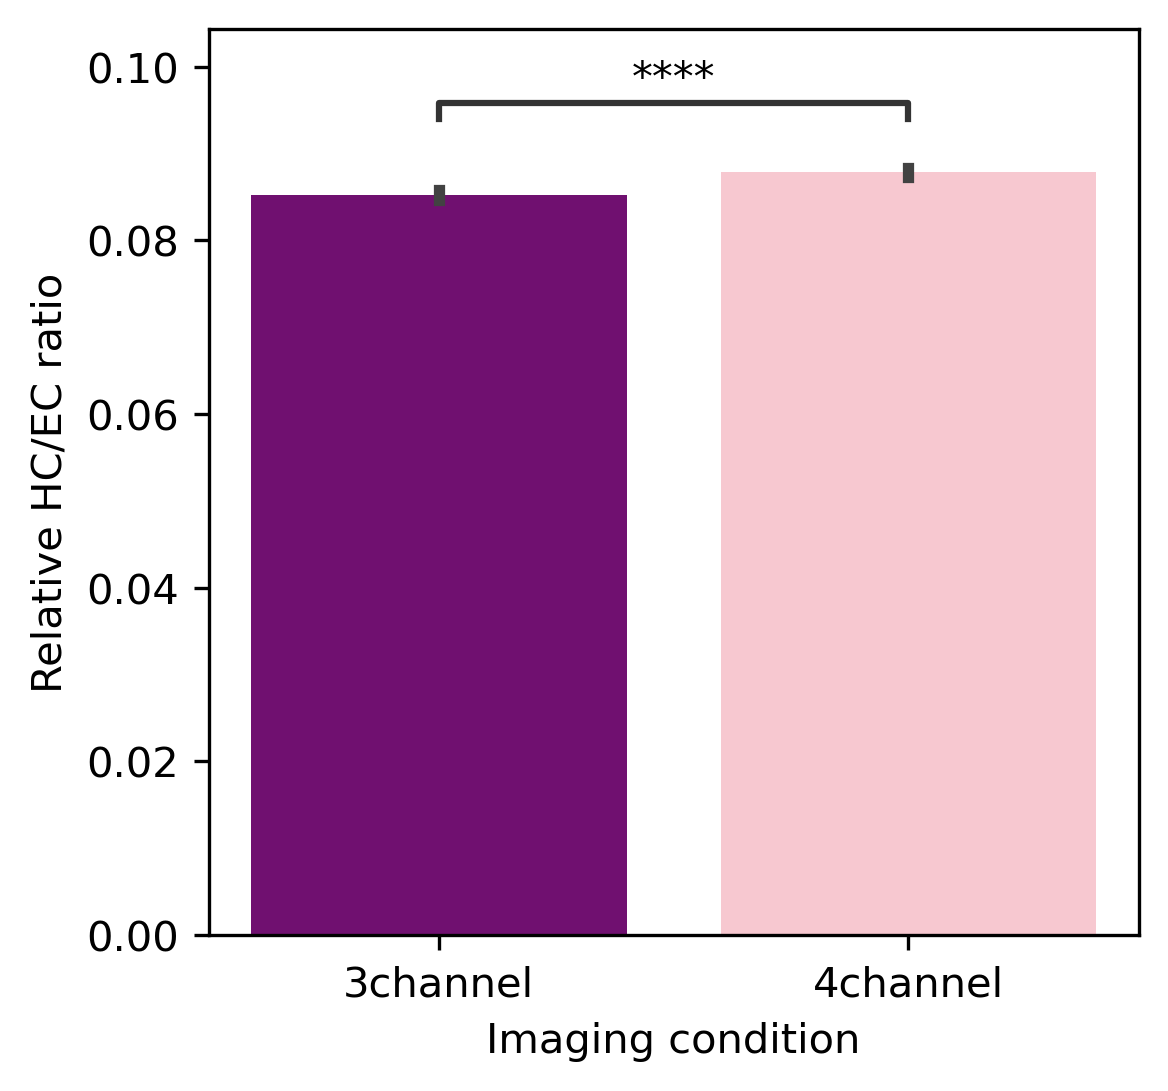

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3channel vs. 4channel: t-test independent samples with Benjamini-Hochberg correction, P_val:5.917e-06 t=4.566e+00


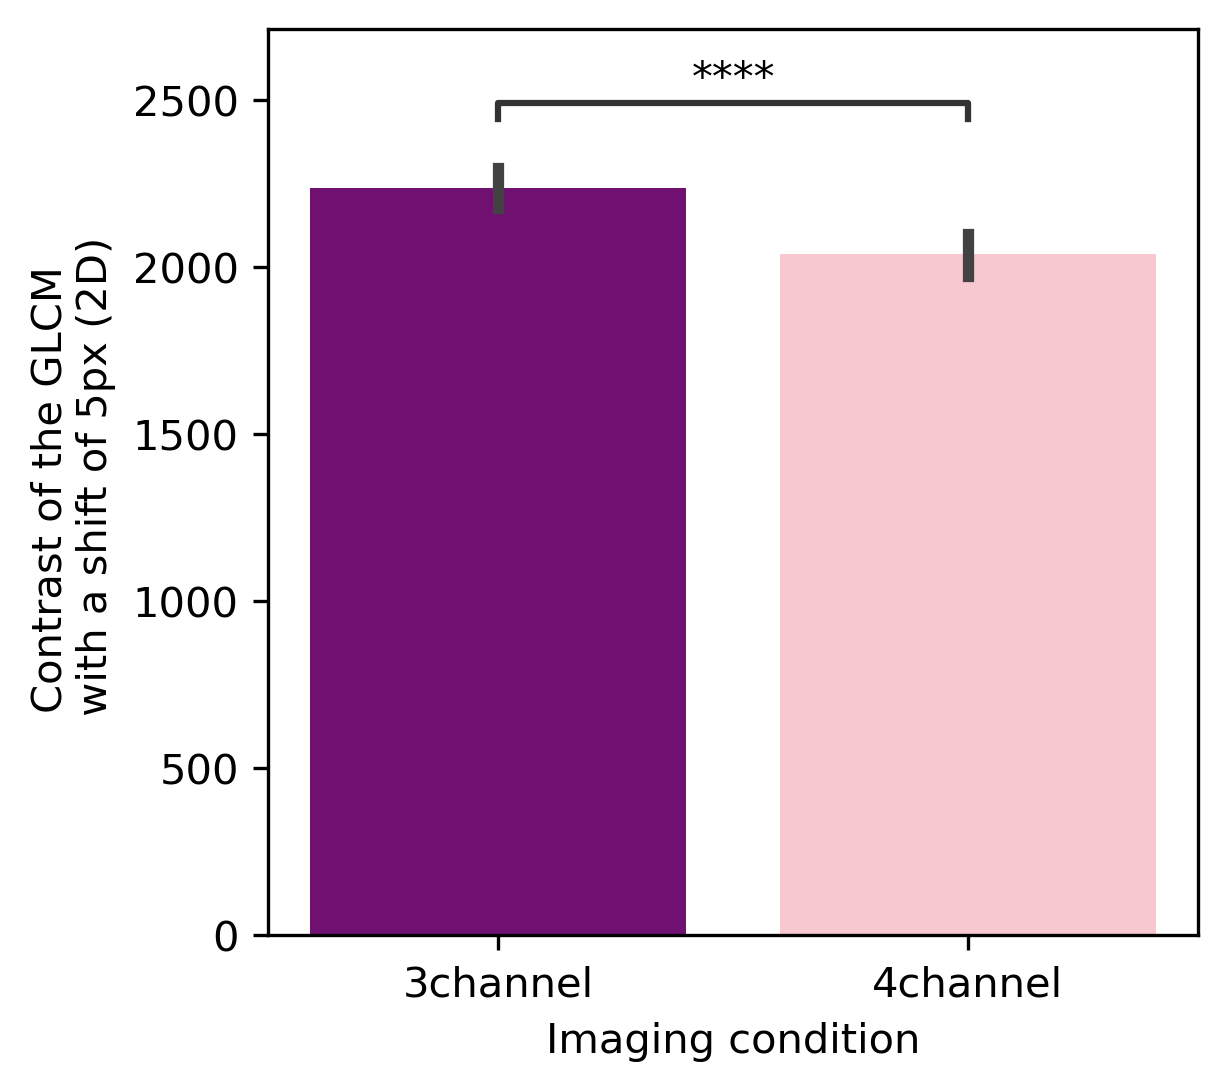

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3channel vs. 4channel: t-test independent samples with Benjamini-Hochberg correction, P_val:2.072e-04 t=3.731e+00


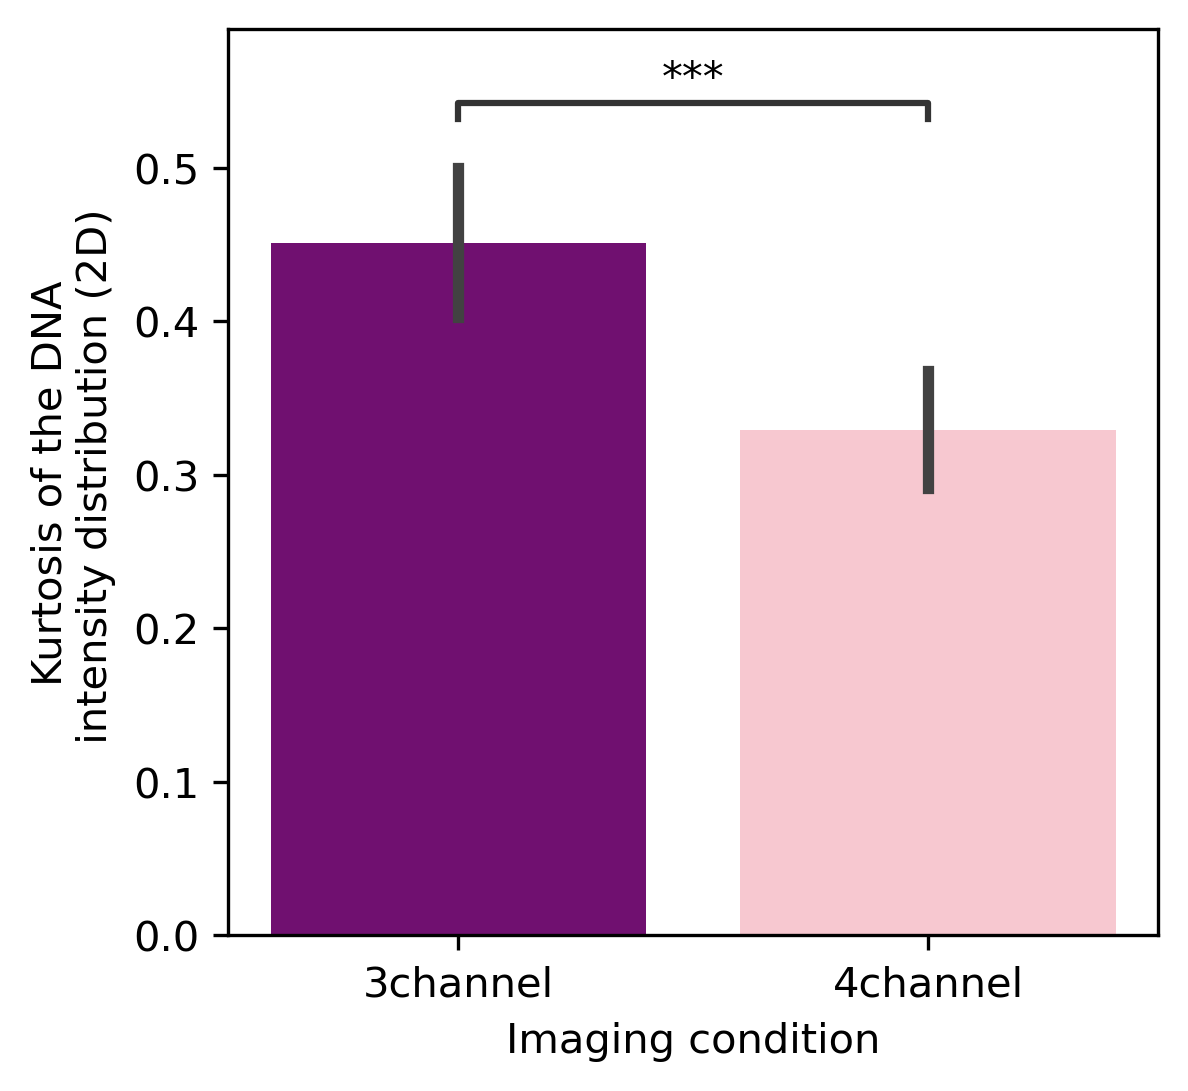

<IPython.core.display.Javascript object>

In [30]:
plot_channel_markers_dist(
    data, markers, marker_labels, cut=0, palette=color_palette, plot_type="bar"
)

---

### 3d. Proteomic differences of PBMCs in cancer

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3channel vs. 4channel: t-test independent samples with Benjamini-Hochberg correction, P_val:9.591e-01 t=5.131e-02


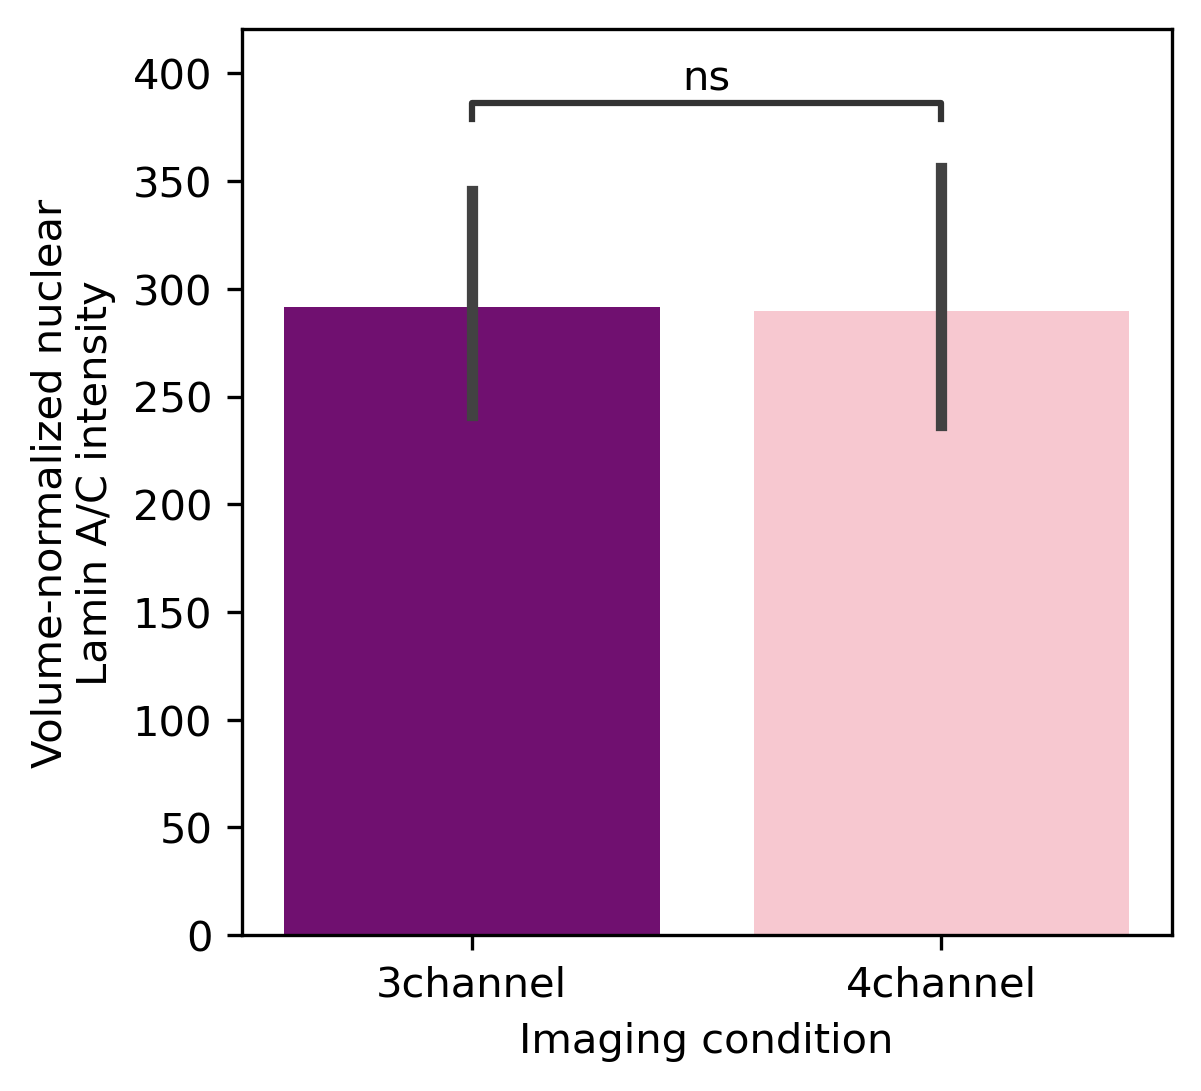

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3channel vs. 4channel: t-test independent samples with Benjamini-Hochberg correction, P_val:3.892e-158 t=3.585e+01


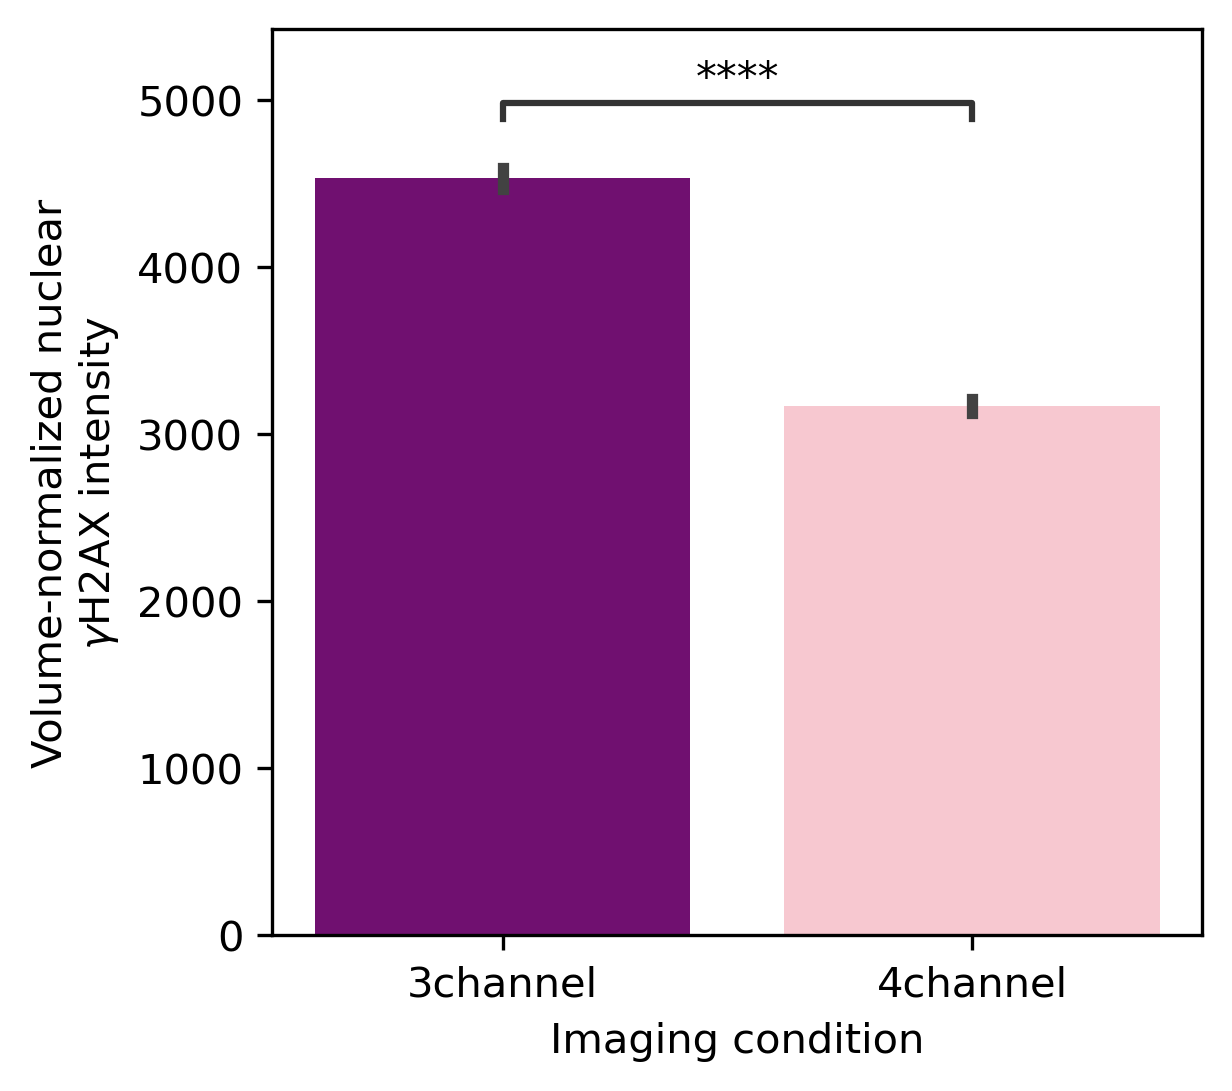

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

3channel vs. 4channel: t-test independent samples with Benjamini-Hochberg correction, P_val:7.042e-07 t=-5.008e+00


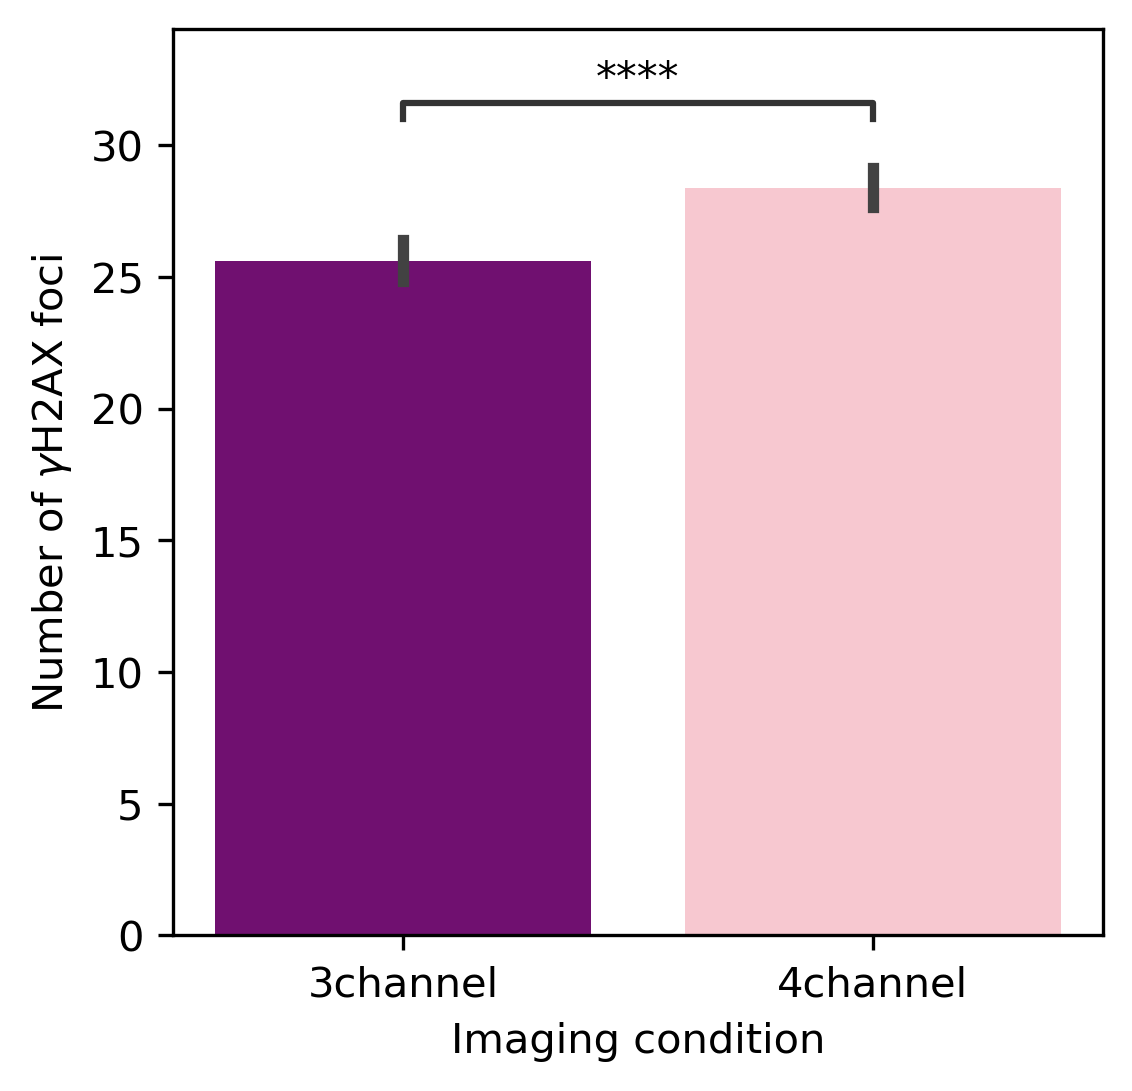

<IPython.core.display.Javascript object>

In [31]:
markers = ["rel_lamin_3d_int", "rel_gh2ax_3d_int", "gh2ax_foci_count"]
marker_labels = [
    "Volume-normalized nuclear\nLamin A/C intensity",
    "Volume-normalized nuclear\n" r"$\gamma$H2AX intensity",
    r"Number of $\gamma$H2AX foci",
]
plot_channel_markers_dist(
    data,
    markers,
    marker_labels,
    quantiles=None,
    cut=0,
    plot_type="bar",
    palette=color_palette,
)

---

## 4. Supplemental